# Introduzione al *VaR* ed alla *Expected Shortfall*
> Copyright Antonio Piemontese 2026

> Si è scelto di usare un notebook, anche se di sole celle di testo (e non anche di codice), perchè un linguaggio markdown del tipo [WYSIWYM](https://it.wikipedia.org/wiki/WYSIWYM), come quello supportato dalle celle di markdown di un notebook, è preferibile ad un editor [WYSIWYG](https://en.wikipedia.org/wiki/WYSIWYG) (ad es. Word) perchè permette di scrivere meglio le formule matematiche. Inoltre è sempre possibile aggiungere celle di codice, se necessario.

# La rilevazione dell'ambiente
**Il presente notebook funziona sia in Jupyter Notebook che Google Colab**.
A questo scopo, per garantire la compatibilità di alcune celle di codice con entrambi gli ambienti indicati, **rileviamo l'ambiente di esecuzione del notebook** (Jupyter oppure Google Colab): la seguente cella imposta una **variabile booleana `IN_COLAB`** che sarà poi **testata** da alcune celle del notebook (in particolare quelle di visualizzazione di immagini e PDF) per personalizzarne il comportamento a seconda dell'ambiente di esecuzione dell'ambiente rilevato.

In [ ]:
# impostazione del TOGGLE BINARIO:
try:
    import google.colab                      # package disponibile SOLO in Google Colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

print("Running on Colab:", IN_COLAB)


# IMPORT dei package necessari (necessari sia in JN, VSC che in Colab):
from IPython.display import Image, display   # import dei package di incorporamento e visualizzazione immagine (una tantum)
                                             # Image e display sono entrambi necessari a Jupyter Notebook
                                             # Google Colab utilizza solo Image
import os                                    # necessario a Google Colab per vedere da una cella codice
                                             # i contenuti del 'content'

In [ ]:
# comando solo per Google Colab
if IN_COLAB is True:
    print(os.listdir('/content'))      # la print è necessaria, altrimenti NON visualizza nulla.
                                       # la funzione 'os.listdir()' infatti restituisce una lista, che poi occorre
                                       # assegnare ad una variabile o passare ad una funzione!

# Le misure del rischio

Una **misura di rischio** esprime in un **unico numero** il rischio legato ad un
investimento. E' un concetto di Risk Management quantitativo. L'idea dietro il concetto di misura del rischio è la seguente:
**maggiore è il valore della misura, più rischioso è l'investimento**.<br> [Non si deve
confondere una misura di rischio (oggettiva) con l'avversione al rischio di un
investitore (soggettiva, rischio percepito).]<br><br>
Da molti anni ormai nel Risk Management finanziario si usano misure di rischio **statistiche**.<br>
Sia [la variabile casuale](https://it.wikipedia.org/wiki/Variabile_casuale) *X* un
**profitto** (*profit*) od il **rendimento di un investimento** (*return*
oppure, in modo equivalente, *rate of return* [^1]). Ogni variabile casuale ha una distribuzione, che associa una probabilità ad ogni valore possibile della variabile casuale. A meno che l'investitore sia [*neutrale al
rischio*](https://www.investopedia.com/terms/r/riskneutral.asp), E[X] - cioè il valore atteso di X - non è
sufficiente [^2]. La misura di rischio più naturale ed immediata è la varianza [var(X) o $\sigma^2$] o
la deviazione standard [devstd(X) oppure $\sigma$], che è la radice quadrata positiva della varianza del profitto
/ rendimento X:

-   la **deviazione standard** è espressa nella stessa unità della variabile X
    (un vantaggio)

-   la **varianza** è più comoda matematicamente (la sua minimizzazione è un
    problema di ottimizzazione convesso: non così la minimizzazione della
    deviazione standard, che contiene la funzione non-lineare radice quadrata).
    <br><br>

> L'uso della varianza come misura di rischio è dovuto anche a ragioni storiche, in particolare la grande diffusione della [teoria del portafoglio di Markowitz](https://en.wikipedia.org/wiki/Markowitz_model), che fa appunto uso della varianza.<br>

[^1]: *Brandimarte 2, footnote a p. 79*

[^2]: *Brandimarte 1, p. 302 fondo*

Molte delle considerazioni teoriche di questo notebook sono ispirate a [questo libro](https://www.amazon.it/Quantitative-Methods-Introduction-Business-Management/dp/0470496347/ref=sr_1_1?__mk_it_IT=%C3%85M%C3%85%C5%BD%C3%95%C3%91&crid=3JPGURL0SA77V&keywords=paolo+brandimarte+quantitative+methods&qid=1702979351&s=books&sprefix=paolo+brandimarte+quantitaive+methods%2Cstripbooks%2C69&sr=1-1) del prof. Paolo Brandimarte del Politecnico di Torino, esperto di Ingegneria Finanziaria, ed ai suoi corsi universitari.

# Nota sui *rendimenti* (return)

Prima di trattare del VaR - è importante distinguere il **V**a**R** (*Value at Risk*) dalla varianza **v**a**r** - facciamo una premessa sui **tipi di
rendimento** (forse superflua per una banca).

Il rendimento (*return*), a volte anche detto *rate of return* [^3], è un cambio
percentuale nel prezzo di una
[**security**](https://en.wikipedia.org/wiki/Security_(finance))[^4]. Occorre distinguere diversi aspetti:<br>

-   rendimenti **azionari** (*stock return*) vs **obbligazionari** (*bond
    return*)

-   rendimento di un **singolo asset** (security: equity, bond, option, ecc) o
    del **portafoglio** aggregato, costituito dalla **media pesata** dei
    rendimenti delle ***n*** security del portafoglio, così calcolata:
    $$r_p = \sum_{i=1}^{n} w_i*r_i$$<br> dove $r_i$ è il rendimento della
    i-esima security e $w_i$ il suo peso nel portafoglio (sono frazioni).

-   ***price*** return vs ***total*** return<br> molte security forniscono
    cash-flow intermedi: ad esempio <u>dividendi azionari</u> (gli stock) oppure
    <u>cedole</u> (i bond). Il *total return* assume il reinvestimento di questi cash
    flow intermedi ed è dunque una misura delle prestazioni dell'investimento
    migliore del price return. Il total return è anche detto *holding period
    return* perchè misura il rendimento sul tempo totale di possesso della
    security. Con *price return* intendiamo qui il rendimento <u>senza</u>
    reinvestimento dei cash flow intermedi, e quindi l'investimento iniziale $W_0$ rimane costante (lo scenario studiato in questo notebook).

-   ***daily*** price return, in seguito indicato con $r_t$: è il price return
    della security nel giorno *t*, calcolato come $r_t$ =
    $\frac{P_t}{P_{t-1}} - 1$ dove $P_t$ è il prezzo della security al giorno
    *t* e $P_{t-1}$ è il prezzo della security al giorno di trading precedente
    *t-1*

-   ***log*** return: è il logaritmo del rendimento, molto usato in finanza, ad
    esempio nel pricing dei derivati. La funzione *logartitmo* ha alcune
    importanti proprietà. [^5] Spesso i rendimenti non sono gaussiani, ma i loro
    logaritmi, sì [ed allora i rendimennti sono *log-gaussiani*].
    Inoltre i log return semplificano il calcolo dei ritorni cumulativi.<br> Il
    log-return $r_t$ è dato da:
    $$r_t = ln(\frac{P_t}{P_{t-1}}) = ln(1 + R_t) = ln(P_t) - ln(P_{t-1})$$<br>
    Cioè, il log return è calcolato come differenza dei log-price (molto
    comodo) ^[Il logaritmo ha la bella proprietà matematica di trasformare i prodotti in somme e le divisioni in differenze].

-   ***cumulative*** return<br> quando si valuta un investimento, si è spesso
    interessati alle prestazioni dell'investimento in un **determinato
    periodo** *T*, cioè si vuole calcolare il rendimento cumulativo (*cumulative
    multi-day return*), ad esempio dell'ultima settimana, o dell'ultimo mese,
    oppure dell'ultimo anno. Il calcolo dei rendimenti cumulativi è facilitato
    dall'uso dei log-return.

-   ***weekly-montly*** return: molto comuni, ad esempio nel calcolo dei *beta*
    [^6]

-   ***gross*** return vs ***net*** return<br> per *(daily) gross return* di una
    security intendiamo qui, in accordo con alcuni autori (non tutti),
    ***1+net-return***. Ad esempio per un rendimento netto del 10% (0.1) si ha un rendimento lordo di 1.1. Il rendimento (lordo o netto che sia è un moltiplicatore del capitale). A fronte di un investimento di 50, con un rendimento netto del 10% e quindi 50x0.10 = 5, si avrà invece un rendimento lordo di 50x(1+0.10)=55.


[^3]: per semplicità ed evitare confusione con altri *rate* (ad es. rate of
    exchange, rate of interest, ecc), preferiamo qui usare il termine *return*

[^4]: *In the investing sense, securities are broadly defined as financial
    instruments that hold value and can be traded between parties. In other
    words, security is a catch-all term for **stocks, bonds, options, mutual
    funds, exchange-traded funds** or other types of investments you can buy or
    sell* - Northwestern Mutual
    
[^5]:
    a)  tende a gaussianizzare i dati, con tutti i vantaggi del caso;
    b)  compatta la scala, facilitando l'esame dei dati, e rende visibili gli
        outlier;
    c) trasforma le moltiplicazioni in somme e le divisioni in
        sottrazioni.

[^6]: *Coefficiente che definisce la misura del rischio sistematico di
    un'attività finanziaria, ovvero la tendenza del rendimento di un'attività a
    variare in conseguenza di variazioni di mercato. Esso è misurato dal
    rapporto tra la covarianza del rendimento di un'attività i-esima con il
    rendimento di mercato, e la varianza del rendimento di mercato: bi =
    covarianza (Ri,RM)/varianza(RM) ove: Ri = Rendimento dell'attività i-esima;
    RM = rendimento del mercato* - Glossario finanziario della Borsa Italiana

Il principale limite della varianza come misura del rischio è di misurare le
deviazioni rispetto al valore atteso <u>sia positive che negative<u>. Ciò non ha senso
da un punto di vista economico: gli extra-profitti non danno certo fastidio! Inoltre,
con una distribuzione simmetrica come la [gaussiana](https://it.wikipedia.org/wiki/Distribuzione_normale), la deviazione standard ha
senso come misura del rischio (può essere applicata solo alle deviazioni
pericolose); ma ciò non vale con le distribuzioni assimmetriche (come, ad
esempio, quelle dei rendimenti dei derivati).<br>

Negli ultimi anni sono state quindi proposte delle misure di rischio
alternative, una delle più famose è il **value-at-risk**.

# Value at risk (VaR)

Cos'è il [VaR](https://it.wikipedia.org/wiki/Valore_a_rischio)? Il VaR è una
*misura* (o *metrica*, oppure *indicatore o KPI*) utilizzato nella gestione
(misurazione) del rischio [^7], e rappresenta la <u>massima</u> perdita
potenziale che può verificarsi per un portafoglio (od un singolo
*asset*, come un'azione od un'obbligazione specifica) posseduto da un determinato
investitore, il 95% delle volte (oppure anche il 99% od altro ancora),
in un dato orizzonte temporale T (detto *holding period*, aka *time horizon*), tipicamente 1 o 10 giorni nella valutazione del rischio di mercato. In questo caso diciamo che stiamo calcolando **il VaR con una
confidenza del 95%** (oppure del 99%, ecc). In realtà, sarebbe meglio dire che **il 5% delle
volte (oppure l'1%, ecc) la perdita sarà maggiore di quanto previsto dal VaR (e potrebbe essere
molto maggiore)**.<br>

Il VaR è probabilmente la misura di rischio **più ampiamente usata** in ambito
finanziario (banche ed assicurazioni). Le framework regolamentative di <u>Basilea e Solvency II le danno grande
importanza</u>.

Nota bene. Una ottima misura di rischio sarebbe ovviamente la "massima possibile loss", che tuttavia è <u>infinita</u> per le distribuzioni di probabilità dei rendimenti più interessanti (e quindi anche della loss, che infatti, come vedremo meglio più avanti, ha la stessa distribuzione del rendimento, con parametri differenti). L'idea del VaR è di **sostituire** questa "massima possibile loss"
con la "<u>massima loss **non superata** con una certa (elevata)
**probabilità**</u>".<br>

In termini economici il VaR è un importo (in euro o dollari, ad esempio), ed anche questo ne ha favorito la diffusione; in termini <u>probabilistici</u> il VaR è semplicemente il **quantile** della
distribuzione della loss, ed è quindi una metrica di rischio *quantile-based* ^[Brandimarte, p. 712+]. In quanto quantile, la sua trattazione risente perciò di alcune **ambiguità** di notazione date dalle differenti definizioni di quantile (all'**europea**: quantile al 95% significa che lascia alla sua sx il 95% ed alla sua dx il 5% ; all'**americana**: quantile al 95% significa che lascia alla sua sx il 5% ed alla sua dx il 95%).

[^7]: Il *downside risk* (o "rischio di ribasso") è una metrica di misurazione
    del rischio finanziario che si focalizza sul quantificare l'entità delle
    possibili perdite associate a un investimento

## La storia del VaR
Il concetto di Value at Risk (VaR) nel risk management finanziario non ha un unico inventore o un punto di origine definito. Esso è evoluto nel tempo ed è stato sviluppato attraverso i contributi di vari individui e istituzioni nel settore finanziario.<br>

Il VaR è emerso come strumento di misurazione del rischio <u>alla fine degli anni '80 e all'inizio degli anni '90</u>. Uno dei momenti chiave nel suo sviluppo è stata l'adozione da parte di **J.P. Morgan** per la sua gestione interna del rischio. La banca in seguito ha reso pubblico il suo modello di VaR sotto il nome di "RiskMetrics" nel 1994, avendo un ruolo significativo nella popolarizzazione del concetto.<br>

Diversi personaggi chiave del settore finanziario hanno contribuito allo sviluppo e al perfezionamento del VaR durante questo periodo. Tuttavia, è importante notare che i concetti di base sottostanti al VaR, come le misure statistiche del rischio e la distribuzione normale dei rendimenti finanziari, hanno radici in teorie finanziarie e statistiche molto più antiche.<br>

Di conseguenza, il VaR è più il culmine dell'evoluzione della teoria e della pratica finanziaria piuttosto che un'invenzione attribuibile a un singolo individuo o momento.

## Distinzioni: Rendimento, Profit & Loss e Loss
<u>Ricapitolando</u>, si danno le seguenti definizioni:<br>

-   **Rendimento** (*return*), che può essere positivo (auspicabilmente) oppure negativo; è una variabile casuale, quindi con una distribuzione di probabiità (nota oppure no) con un valore atteso ed una deviazione standard; è calcolato in vari modi per differenza tra i prezzi di due unità (giorni, settimane, mesi, ecc) successive nel tempo;

-   ***Profit & Loss*** (abbreviato *P&L*) = valore finale dell'asset (o del portafoglio - vedi più avanti) - valore iniziale

-   ***Loss*** (perdita) = valore iniziale dell'asset (o del portafoglio) - valore finale. E' l'opposto del P&L, cioè *-P&L*.

> La loss (anzichè il P&L) semplifica l'applicazione di molti metodi
statistici ed è in linea con le convenzioni della moderna teoria del rischio
attuariale [QRM, p. 48]. La loss inoltre corrisponde intuitivamente alle
preoccupazioni dell'investitore.<br>

La ***loss*** è la perdita di valore dell'asset o portafoglio nel periodo considerato. La loss, in quanto **differenza tra il valore iniziale dell'asset (o portafoglio) e quello finale**, è spesso (auspicabilmente!) <u>negativa</u>, ed è quindi in genere considerata **in valore assoluto**, cioè $|Loss|$:
* perchè la coda sx del P&L può essere negativa, quando il rendimento è negativo, e dunque il valore finale è inferiore a quello iniziale;
* non si usa il segno '-' perchè la coda sx del P&L può anche essere positiva, quando il rendimento minimo è comunque di segno positivo ^[*Clifford Ang*, nota mia a pag. 120].

Un'ottima derivazione matematica della formula della loss $L_T$ è la seguente ^[*Brandimarte*, p. 712]:<br>

In [1]:
Image('Brandimarte1_712.png',width=1000) if IN_COLAB else display(Image(filename='Brandimarte1_712.png'))

NameError: name 'IN_COLAB' is not defined


Nel caso di periodi temporali medio-lunghi non è più possibile ignorare il
valore tempoorale del denaro, e dunque la precedente definizione di loss non è
più praticabile. In questi casi si preferisce allora definire la loss come:

$$\frac{(valore.iniziale - valore.finale)}{(1 + r_{t,1})}$$

dove $r_{t,1}$ è il **tasso di interesse risk-free**.

## Metodi di calcolo del VaR

Esistono almeno **tre metodi di calcolo del VaR**, meglio comprensibili se si
mettono in relazione la distribuzione della *loss* con la distribuzione del
rendimento (*return*) [^8]:

-   VaR *analitico*

-   VaR *storico*

-   VaR *simulato* (ad esempio con il metodo di Montecarlo)

Vedremo ora ognuno dei tre metodi di calcolo del VaR. Per semplicità inizialmente supponiamo che
il nostro ipotetico investitore abbia un solo titolo azionario nel proprio
portafoglio e che il periodo di detenzione *T* (in giorni, settimane, mesi, od anni) sia
pari a 1.<br>

[^8]: *Brandimarte 1, p. 712*

## VaR analitico

Il calcolo del VaR in modo analitico (cioè con una formula) è semplice sotto **tre assunzioni** (non scontate!), e cioè che:
* il **rendimento** $R_T$ dell'asset (o del portafoglio, vedi più avanti), e quindi anche della loss $L_T$ sia distribuito in modo **gaussiano**
(cioè [*normale*](https://it.wikipedia.org/wiki/Distribuzione_normale))
* che $E[R_T] \approx 0$. $E[R_T]$ è anche detto $\mu_{R_T}$, in quanto parametro centrale della distribuzione gaussiana.
* e che $var(R_T)$ sia nota, ad esempio per esperienza o per teoria, oppure stimabile dai dati storici ^[*Brandimarte*, p. 714 top.]. $var(R_T)$ è anche detta $\sigma^2_{R_T}$ in quanto parametro di dispersione della distribuzione gaussiana.<br>

Si distinguono due casi, a seconda del valore
di *T* (1 o molti periodi): VaR analitico **semplice** oppure VaR analitico **multi-periodo**.<br>

Il periodo può essere il giorno, la settimana, il mese, l'anno, ecc - dipende dal problema.

### VaR analitico semplice

*T* = 1.<br> Tramite uno sviluppo matematico non banale e descritto più avanti in una nota matematica, si passa dalla definizione di *loss* vista prima alla seguente formula di definizione del VaR ^[*Brandimarte*, p. 714]:

$VaR_{1-\alpha} = z_{1-\alpha}{\sigma}W_0$

dove:<br>
* $W_0$ è il valore investito (in un singolo asset od in un portafoglio) al momento iniziale<br>
* $\sigma$ è la volatilità del rendimento dell'asset (o del portafoglio), cioè la sua deviazione standard (la radice quadrata positiva della varianza); in modo più preciso è quindi $\sigma_{R_T}$<br>
* $z_{1-\alpha}$ è il quantile $(1-\alpha)$ della distribuzione gaussiana standard (in statistica indicata come *Z*). Nella formula suddetta rappresenta una costante. Valori tipici
di $\alpha$ sono **0.01** e **0.05**. ma a volte si usa anche 0.005. $\alpha$ rappresenta il livello di rischio accettabile per l'investitore, cioè la **tolleranza** al rischio.<br>
* (1 - $\alpha$) è il **livello di confidenza**.<br>

Da questa formula si ricava che, a parte il capitale investito $W_0$, il VaR (analitico ma non solo) ha **3 ingredienti chiave**:
* la volatilità del rendimento
* l'intervallo di confidenza
* l'orizzonte temporale (qui T = 1)
<br>

> Questa formula deve produrre un quantile della distribuzione della loss (per la definizione di VaR, appunto) - cioè un valore di loss! - ed infatti moltiplica un quantile (della gaussiana standard) per la variabilità per l'investimento. Ciò intuitivamente produce un quantile della loss. Con il segno '-' per avere una loss positiva!<br>

Si noti che in questa formula NON è presente $\mu_{R_T}$, aka $E[R_T]$ (il valor medio del rendimento dell'asset o del portafoglio), perchè assunto approssimativamente uguale a 0, un'ipotesi sostenibile in un breve periodo.<br>

Poichè $L_T = -W_0R_T$ (vedi prima), e per le tre precedenti assunzioni (sul rendimento), si ha che: $L_T \sim N(0,W_0^2\sigma^2)$. Vedi anche le note matematiche più avanti.<br>

Vediamo un **bell'esempio** di applicazione del VaR analitico semplice, con due differenti livelli di confidenza [*Brandimarte*, p. 714].

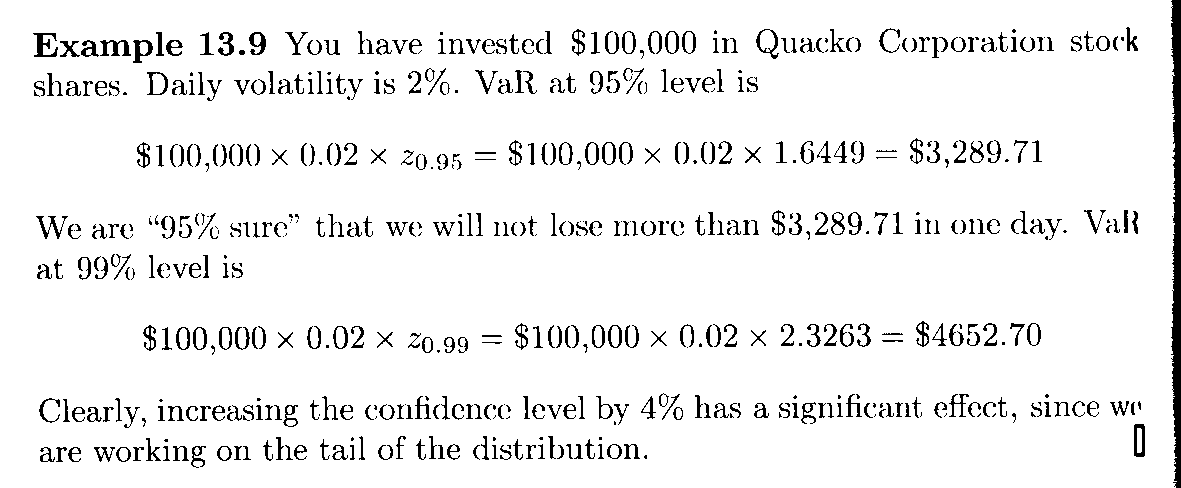

In [ ]:
Image('esempio_13_9.png',width=600) if IN_COLAB else display(Image(filename='esempio_13_9.png'))

Relativamente all'esempio 13.9 ora mostrato, la volatilità del rendimento (deviazione standard) <u>giornaliera</u>, se non nota, può essere ottenuta come:<br>

$$
\sigma_{giorn} = \frac{\sigma_{ann}}{\sqrt{252}}
$$

dove il numeratore è la volatilità <u>annua</u> (**più facilmente nota**) e 252 è il numero di giorni lavorativi dell'anno [vedi QRM p. 71; Brandimarte p. 327 e Clifford Ang]. Si tenga comunque conto che, se la distribuzione del rendimento annuale è gaussiana, non necessariamente lo è anche quella del rendimento giornaliero, e che quindi la regola gaussiana del +- 3$\sigma$ non vale più [vedi *Brandimarte*, Example 7.14 a pag. 327.].<br>

Oltre a quella qui sopra riportata, esistono **altre definizioni matematiche di VaR**, ad esempio:
* VaR *assoluto* e VaR *relativo*, che comunque coincidono sotto le tre assunzioni prima riportate sui rendimenti ^[*Brandimarte*, p. 713]);
* oppure quella di Clifford Ang (p. 119) o di Karasan, pp. 126-127, matematicamente equivalenti a quella di Brandimarte. Nel notobook Python useremo la definizione di VaR analitico di Karasan, che sarà li fornita.<br>

Per convenzione di mercato si parla spesso di VaR (in questo esempio ad **1 giorno**)
all'1% ed al 5%, perchè prevale la definizione americana di quantile. Come già detto, $\alpha$ è il livello di **significatività**, 1-$\alpha$ è il
livello di **confidenza**.<br>
Sempre per convenzione di mercato, come detto prima, il **VaR - che è un quantile , come detto - è un
valore positivo** perchè è il  VaR della distribuzione della loss.<br>.

[^9]: *Brandimarte 1, p. 714 e 327*

> **La stima di $\sigma$**<br>
Spesso $\sigma$ <u>non è nota</u>, nè quella giornaliera nè quella annua, e dunque la dobbiamo **stimare dai dati**.<br>
Poichè qui assumiamo che il rendimento (e quindi anche il *P&L* e *Loss*) sia distributo in modo gaussiano,
**1 anno** (cioè circa 252 osservazioni) di rendimenti giornalieri è considerato sufficiente per stimare $\sigma$ (e $\mu$). Al contrario, il calcolo del VaR <u>storico</u> richiede **3-5 anni di dati** perchè NON si assume la gaussianità e quindi la stima dei due momenti di primo (media) e secondo (std) ordine è più esigente in termini di quantità di dati, per essere affidabile - vedi più avanti [^10]].<br>

[^9]: *Brandimarte 1, p. 714 e 327*

[^10]: è una regola pratica di molti esperti di Financial Models (*Clifford Ang, p. 118*)

Nel calcolo del VaR, l'orizzonte temporale *T*, che dovrebbe riflettere **l'holding period** (il periodo di possesso) del
portafoglio, dipende dal <u>tipo di rischio modellato</u> ^[libro *QRM*, p. 64]:

-   è in genere di **1-10 giorni** nella gestione del **market risk** (e quindi
    anche dell'**interest rate risk**),

-   è in genere di **1 anno** nella gestione del **credit risk** e
    dell'**operational risk**,

-   è comunque **lungo** nella gestione del **liquidity risk** se la security è
    "illiquida" o comunque il mercato per quell'asset non è molto liquido,

-   nella **limitazione del trading** (trading limits), una banca tipicamente
    fissa: ***T*** **= 1 giorno (ed alfa = 0.05)**

-   **per il rischio di mercato nel trading bank of book**, <u>Basilea</u> fissa
    <u>T = 10 giorni</u> (ed alfa = 0.01), Solvency II fissa ***T*** **= 1 anno**
    ed alfa = 0.005.

> Considerazioni pratiche suggeriscono comunque di mantenere ***T***
    **piccolo**, poichè:<br>
    i) l'assunzione che la composizione del portafoglio rimanga invariata non regge per periodi medio-lunghi (infatti, ad esempio in un anno, i titoli del portafoglio possono maturare ed essere sostituiti da altri e gli interessi o dividendi possono essere re-investiti);<br> ii) se T è piccolo, inoltre, ci sono più dati a disposizione per la stima dei parametri del rendimento (in particolare di $\sigma_{R_T}$) e per il calcolo del VaR storico.

#### Note

**Nota matematica**: [^12]<br>

Questo calcolo è semplice grazie all'assunzione di **gaussianità del
rendimento**: $R_T$ \~ ${N(\mu_{R_T},{\sigma_{R_T}^2)}}$ con $\mu_{R_T} = 0$ e
$var(R_T) = {\sigma_{R_T}^2}$ (assunta o <u>campionata)</u>.]<br>

Poichè $L_T$ = $-W_0R_T$, si ha: $L_T$ \~ $N(0, {W_0}^2{\sigma^2_{R_T}})$ [^13] e, con
analogo ragionamento, anche la *Profit&Loss* è gaussiana.

Come già detto precedentemente, nella formula del VaR [$VaR_{1-\alpha} = z_{1-\alpha}{\sigma}W_0$] non c'è
$\mu_{R_T}$ perchè assunto uguale a 0.

[^12]: *Brandimarte 1, p. 714 top*

[^13]: la moltiplicazione o divisione di una variabile casuale gaussiana con
    parametri $\mu$ e ${\sigma}^2$ per una costante *c* è ancora gaussiana con
    nuovi parametri ${\mu}c$ e ${\sigma^2}c^2$ - Vicario, p. 91

Ecco lo **sviluppo matematico completo** per arrivare alla formula del VaR analitico
semplice:

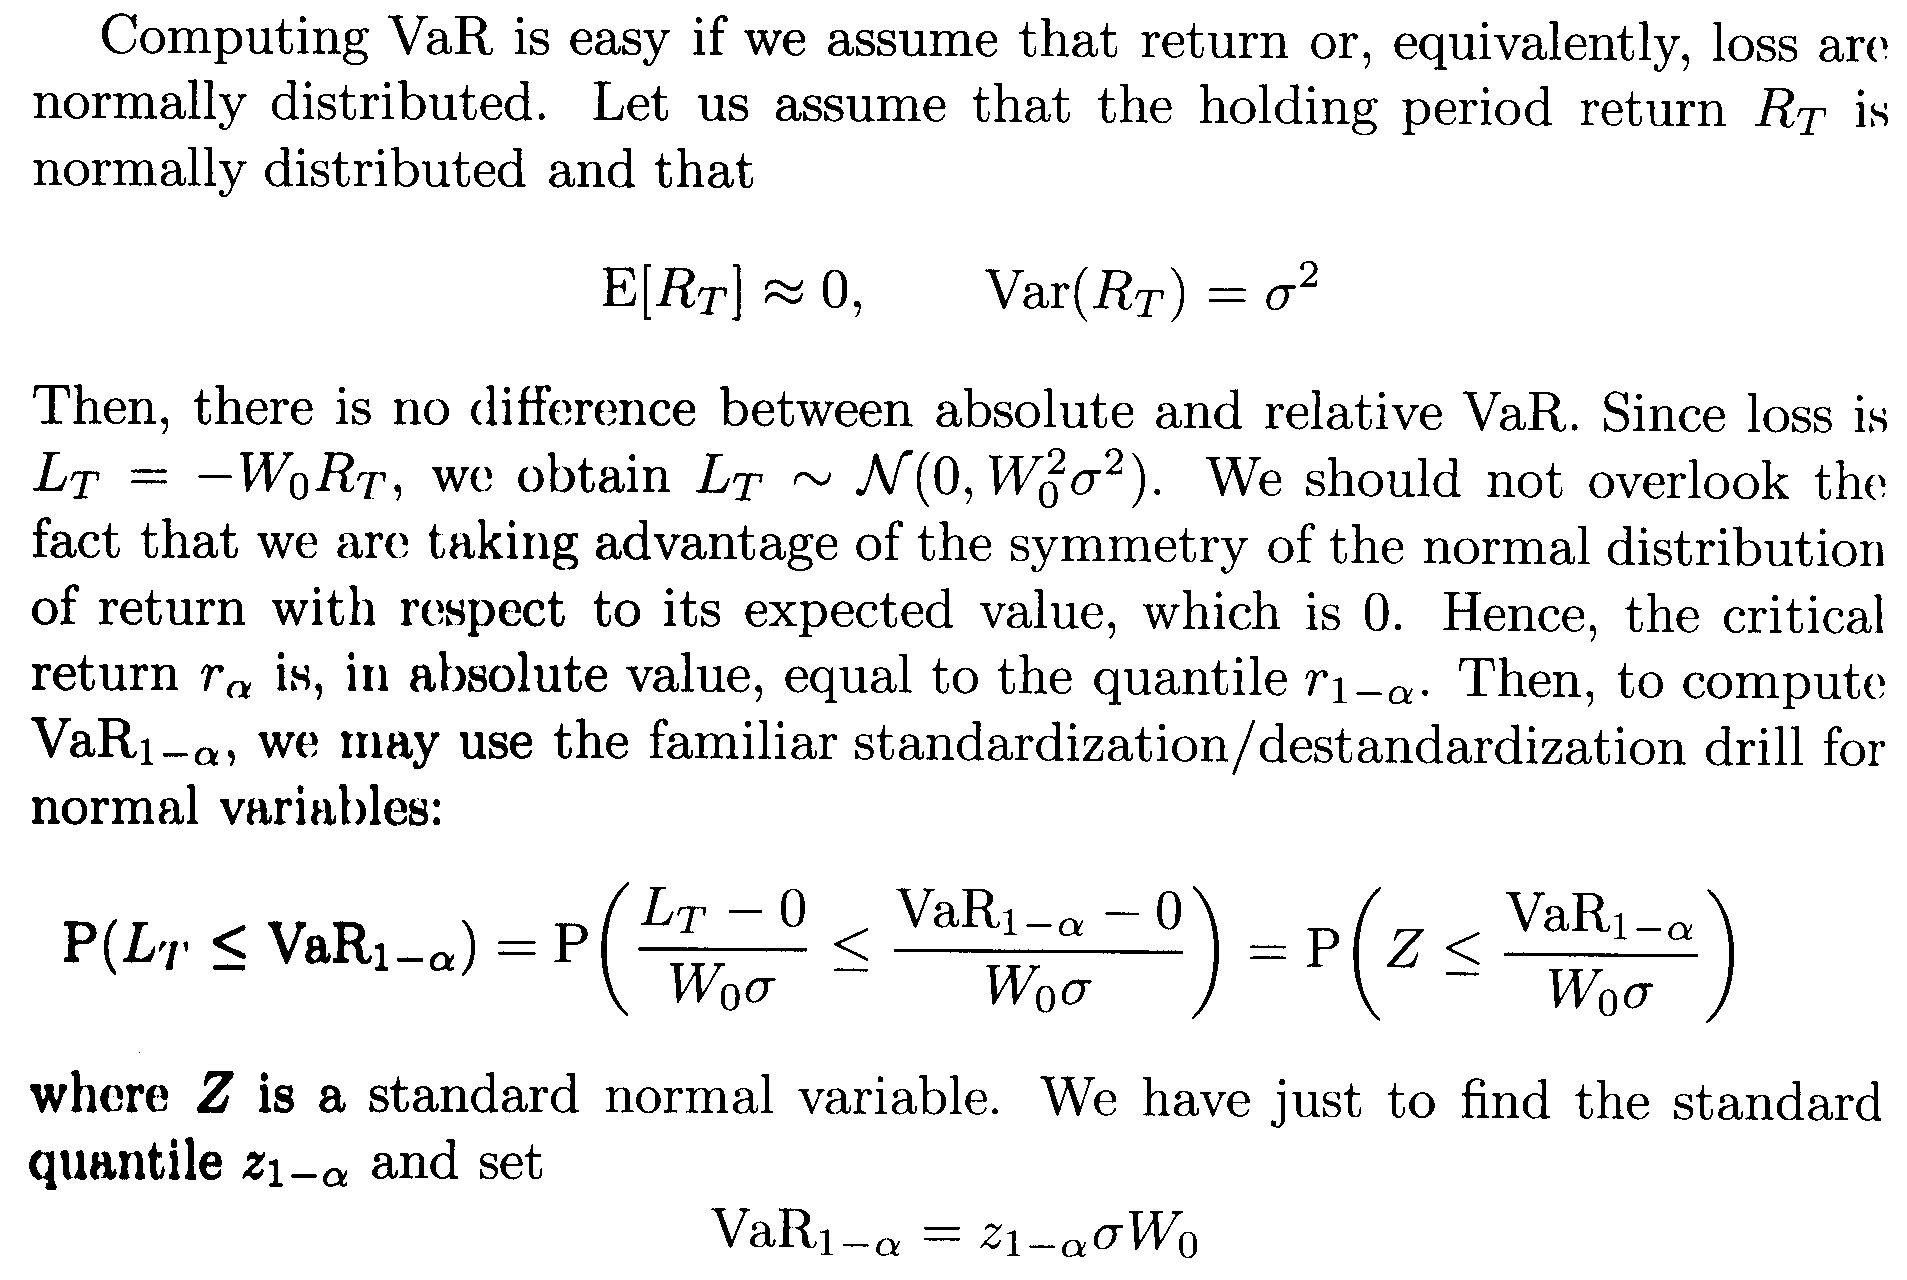

In [ ]:
Image('Brandimarte1_714top.png',width=600) if IN_COLAB else display(Image(filename='Brandimarte1_714top.png'))

### Un caso più realistico?

Si esamini il seguente grafico di esempio della distribuzione della loss, interessante sotto diversi aspetti:<br>

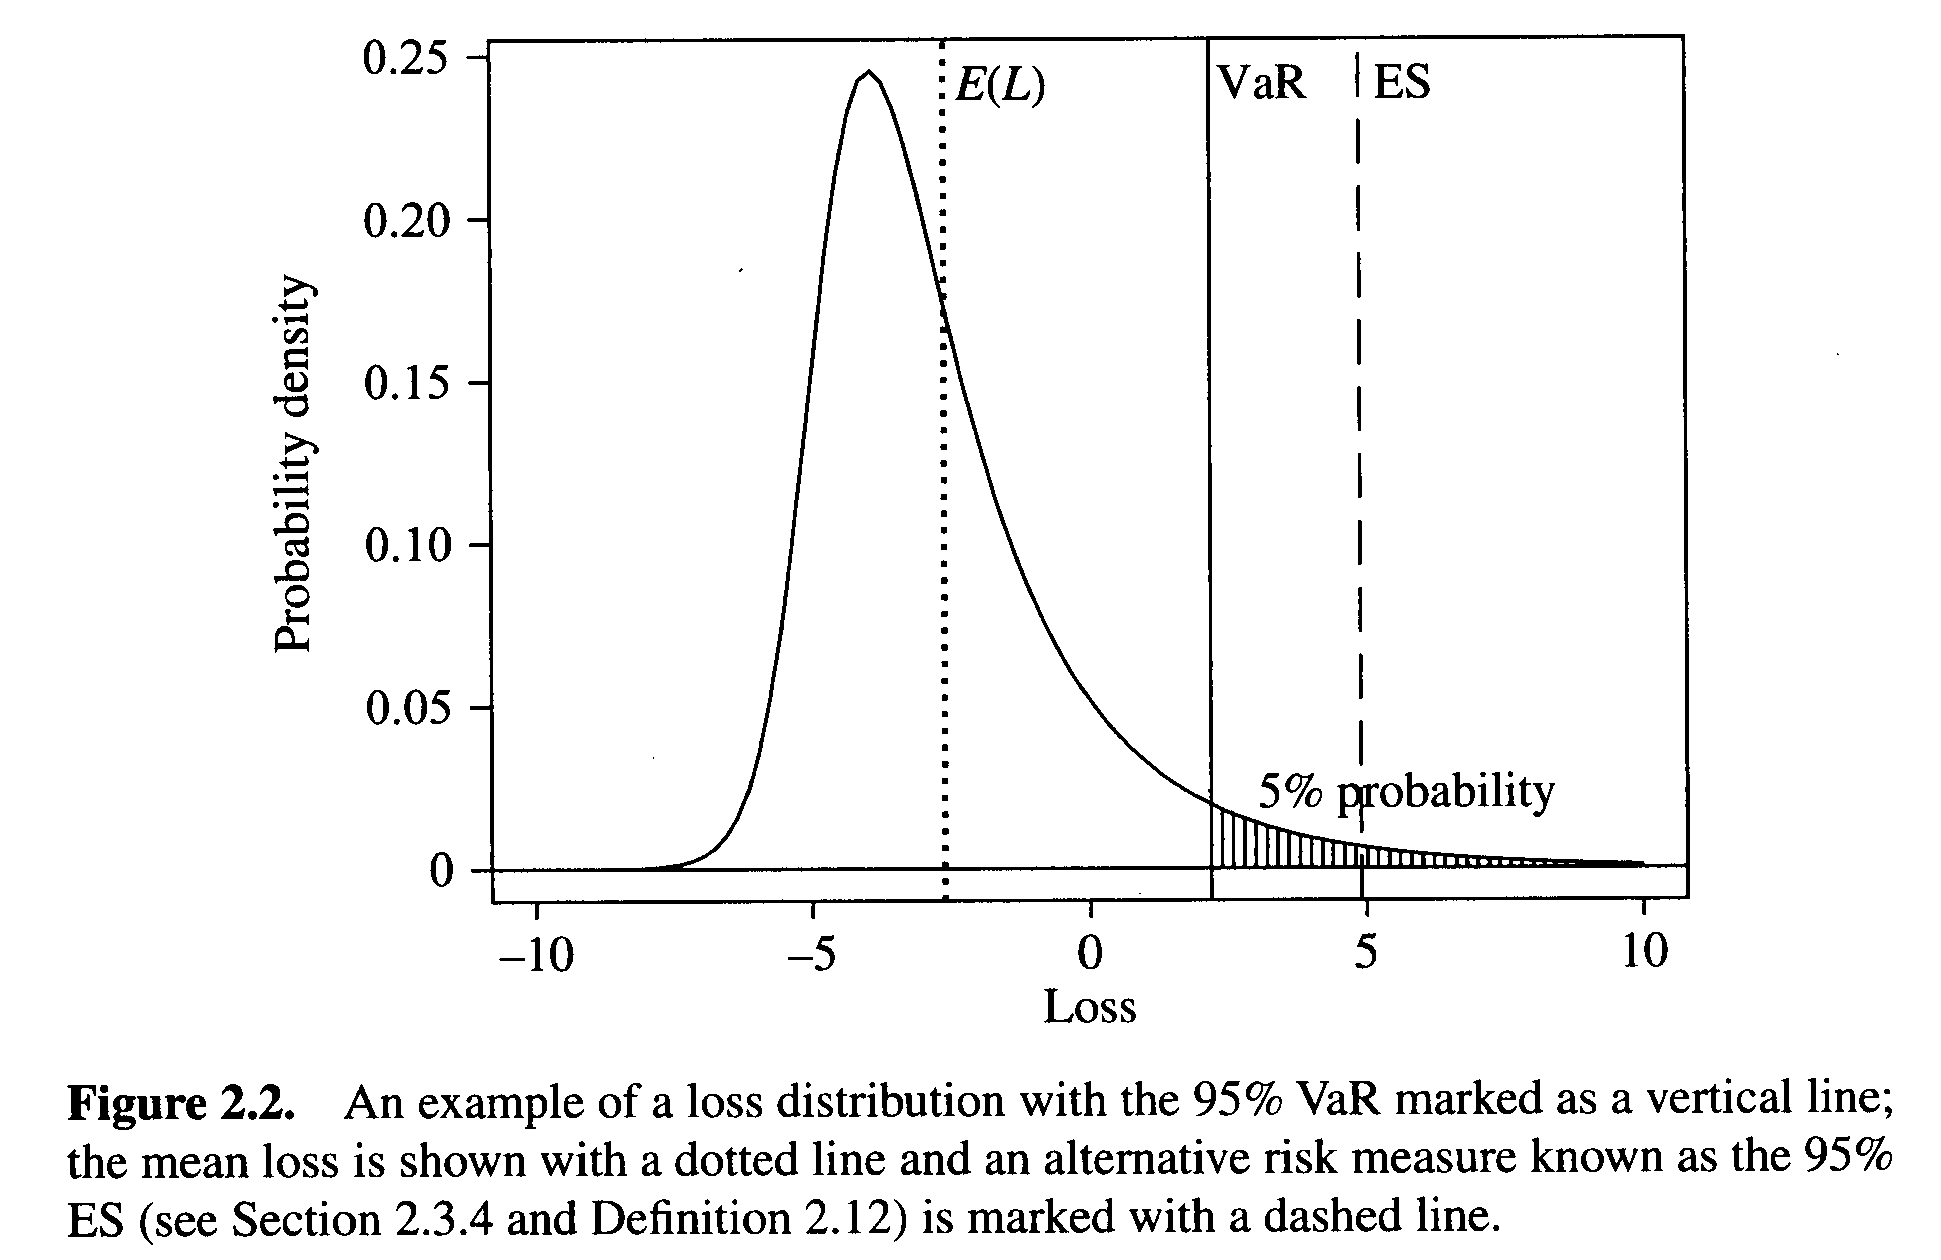

In [ ]:
Image('QRM_Fig_2_2.png',width=1000) if IN_COLAB else display(Image(filename='QRM_Fig_2_2.png'))

Si noti che:

-   la distribuzione non è gaussiana e non è neanche simmetrica

-   la coda dx della distribuzione è molto più lunga della sx --\> rischio di
    loss elevata

-   la loss media è negativa (E[L] = -2.6), indicando che ci aspettiamo un
    profitto (**qui non si è usato |loss|**, come si fa invece in genere)

-   il VaR al 95% ($(1-\alpha)$ all'europea) è circa 2.2. Secondo la classica interpretazione del VaR vista prima più volte, ciò significa che c'è
    una probabilità del 5% che perdiamo almeno questo ammontare, oppure maggiore.

#### L'assunzione di gaussianità del VaR analitico

L'assunzione di gaussianità dei rendimenti e della loss può anche essere pericolosa, perchè
la gaussiana ha una curtosi abbastanza bassa (3) e "gli estremi sono importanti nella misurazione del rischio" ^ [*QRM*, p. 35 e *Brandimarte* 2, p. 80]. Sono perciò state suggerite altre distribuzioni alternative, con code più piatte,
in modo da tener conto dei *rischi di coda*, che sono la principale
preoccupazione di un Risk Manager. Tuttavia, la distribuzione gaussiana è così
semplice da costituire sempre una prima ipotesi. Ad esempio, la distribuzione
[*t di Student*](https://it.wikipedia.org/wiki/Distribuzione_t_di_Student), anch'essa simmetrica ma più piatta,
richiede la stima anche dei gradi di libertà.<br> L'uso della distribuzione
gaussiana (cioè normale) nasconde quindi importanti presupposti che spesso sono
fondamentali da verificare <u>precedentemente</u> per garantire l'affidabilità dei metodi analitici.<br>

### VaR analitico con la *t di Student*
Se, per il calcolo del VaR (e più avanti della ES), si usa il modello con la distribuzione *t di Student*, un problema pratico è: **quanti gradi di libertà usare?** (il parametro $\nu$).<br>

> When calculating parametric Value at Risk (VaR) using the Student's t-distribution, the degrees of freedom play a crucial role in determining the shape of the distribution and, consequently, the risk assessment.<br>
In the context of the t-distribution, the degrees of freedom (often denoted as "ν" or "df") represent a parameter that influences the fatness of the tails of the distribution. The higher the degrees of freedom, the closer the t-distribution approximates a normal (Gaussian) distribution with thinner tails. Conversely, lower degrees of freedom result in thicker tails, indicating greater uncertainty or volatility.<br>
Typically, in financial risk management and statistics, you'll encounter two common scenarios regarding degrees of freedom:
> 1. If you have a large sample size and the data closely resembles a normal distribution, you can use a t-distribution with a high degree of freedom, such as 30 or more. In this case, the t-distribution is very similar to a normal distribution.
> 2. If you have a small sample size or believe that the data has heavier tails than a normal distribution (indicating more extreme outcomes), you might use a t-distribution with fewer degrees of freedom, which has thicker tails. This acknowledges the additional uncertainty associated with a smaller sample or the presence of outliers.<br>

> In the context of calculating VaR, selecting an appropriate degree of freedom is essential to capture the risk accurately. A higher degree of freedom might be suitable for less volatile and normally distributed data, while a lower degree of freedom might be more appropriate for data with higher volatility or potential extreme events. The choice of degrees of freedom should align with the characteristics of the data being analyzed to provide a realistic estimate of VaR.<br>

Per un ottimo confronto tra il VaR analitico con la gaussiana e quello con la *t di Student* vedi [questo post](https://quantatrisk.com/2015/12/02/student-t-linear-value-at-risk/).

### VaR analitico multi-periodo

E' possibile estendere il calcolo del VaR analitico al **multi-periodo** (*T* \>
1), cioè calcolare il VaR sul multi-periodo [^14]. Assumendo che i
rendimenti dei *T* periodi (ad esempio *T* giorni) siano
[**iid**](https://it.wikipedia.org/wiki/Variabili_indipendenti_e_identicamente_distribuite) - ma spesso invece sono [auto-correlati](https://it.wikipedia.org/wiki/Autocorrelazione) - si ha:<br>

$VaR_{1-\alpha} (T giorni) = z_{1-\alpha}\sqrt{T}{\sigma}W_0$

dove semplicemente si è moltiplicato il secondo membro della formula del VaR
semplice per $\sqrt{T}$. Questa formula è ottenuta applicando la cosiddetta
regola della radice quadrata ([*square-root rule*](https://gregorygundersen.com/blog/2022/05/24/square-root-of-time-rule/)).<br> Si noti che, se *T* è
breve (ad esempio, 1 giorno) - come spesso avviene, perchè le regolazioni bancarie richiedono di coprire le possibili perdite a breve termine (*short-term* losses) - la **volatilità del rendimento multi-periodo
(**$\sigma\sqrt{T}$) domina sul valore atteso (${\mu}T$) perchè $\sqrt{T}$ va a
0 più lentamente di T. [^15].<br> La formula ora vista è molto semplice,
tuttavia non considera alcuni aspetti importanti [^16], in particolare:

-   il periodo T può essere **lungo**, e non possiamo ipotizzare rendimento
    medio = 0 (in un periodo lungo); speriamo anzi che non sia zero! <br>
    In questi casi si può utilizzare il **VaR relativo** (vedi il notebook in python).

-   la possibile **correlazione** tra i vari rendimenti (modellabile tramite la matrice di varianza-covarianza $\Sigma$), cpme vedremo più avanti nel caso multi-variato

-   gli interessi **composti**

-   senza contare, come anche per il VaR semplice, **l'inflazione**.

> Durante gli **stress test** si considerano tutti questi fattori. In generale, comunque, si tenga presente che tra i vari rischi finanziari c'è anche il **rischio di modello (*model risk*)**, ovvero il rischio che il modello di distribuzione della loss non sia ben specificato. **Il VaR non è una misura esatta** (neanche dato un certo livello di confidenza), come a volte è invece erroneamente interpretata: ci sono l'errore di stima, il rischio di modello ed il rischio di liquisità del mercato, ovvero il fatto che il tentativo di liquidare una voluminosa posizione in perdita possa contribuire ad alzarne il prezzo, quindi aumentando la loss (QRM, p. 67).<br>

Vedremo un'applicazione della prima citata regola della radice quadrata
(*square-root rule*) in un esempio successivo, applicato al calcolo del VaR
storico. <br> **Non si confonda** il <u>il numero dei periodi T</u>, sul quale vogliamo calcolare il VaR, con l'unità di misura di T (giorno,settimana, mese, anno) .

*Si sta anche assumendo, come detto prima, che il rendimento del singolo asset non sia autocorrelato nel tempo, cioè su giorni consecutivi. E' bene verificare preliminarmente questa assunzione, spesso non rispettata dai dati, come appunto faremo nel notebook in python*.

[^14]: il rendimento con T>1 è una combinazione lineare (una somma con pesi tutti 1) dei *T* rendimenti unitari,
    quindi con parametri gaussiani ${\mu}T$ e $\sigma\sqrt{T}$. In altre parole, il valore
    atteso di una somma di variabili è sempre uguale alla somma dei valori attesi delle variabili e la varianza di una somma di variabili è sempre uguale alla somma delle varianze se le
    variabili sono indipendenti (questa proprietà NON vale per le deviazioni
    standard). A volte studenti ed anche professionisti sono confusi da
    $\sigma\sqrt{T}$: **il rendimento multi-periodo è una variabile casuale
    definita come la somma di *T* rendimenti, cioè *T* variabili casuali; non è
    il prodotto di *T* per una variabile casuale**, perchè in questo secondo
    caso si assumerebbe che il rendimento giornaliero si sia <u>realizzato</u> e
    poi si sia replicato per *T* giorni. Ma questo non è il fenomeno in atto. Si
    veda in proposito *Brandimarte 1, pp. 327-328*.

[^15]: *Brandimarte 1, pag. 713, footnote 13*

[^16]: *Brandimarte 1, p. 714 e 327*


> NB. Un errore tipico di molti professionisti finanziari è di considerare la variabile casuale $R_{k-giorni} = KR_{R_1-giorno}$. Il fenomeno casuale non si realizza in questo modo; al contrario la variabile casuale è: $R_{k-giorni} = \sum_{i=1}^{k} R_i$. [Brandimarte, p. 327]

#### Drift vs Volatility

Definizione di **drift**: "An indicator for the deviation of the investor's
portfolio's holdings from their target weightings. Drift occurs as individual
securities in the portfolio appreciate or depreciate in value and veer off of
their original allocations over time." [Financial
Glossary](https://ycharts.com/glossary/terms/drift#:~:text=Is%20an%20indicator%20for%20the,their%20original%20allocations%20over%20time.)<br>
E' intuitivo comprendere che il **drift** del portafoglio è relativo al valore
atteso del profit&loss, mentre la **volatilità** del portafoglio è relativa alla
deviazione standard. Si noti che, per la *square-root rule* prima citata, in un
breve periodo T il drift scala <u>linearmente</u> con T, mentre la
volatilità è proporzionale a $\sqrt{T}$; il che significa appunto che, **se T tende a
zero, il drift tende a zero più velocemente di quanto faccia la volatilità**.<br>

### VaR analitico del portafoglio

In pratica, come già detto, le banche non sono interessate al VaR per un singolo asset, ma al **VaR di un portafoglio** (ad  esempio in azioni, obbligazioni e derivati), spesso <u>multi-periodo</u>, ed i cui asset hanno rendimenti **non indipendenti tra loro!**<br>

> La formula lineare che definisce il **valore** del portafoglio al tempo *t* (giorno, settimana, mese, ecc) è la seguente:

> $$p_t = W^{asset-1}R_t^{asset-1} + W^{asset-2}R_t^{asset-2} ..... + W^{asset-n}R_t^{asset-n}$$

> dove $W^{asset-i}$ è il valore iniziale investito nell'asset *i* e $R_t^{asset-i}$ è il rendimento al tempo *t* dell'asset *i*.<br>

Si usano in genere <u>due assunzioni semplificatrici</u> (accettabili solo se il periodo di detenzione del portafoglio è breve - ad esempio pochi giorni):
* la composizione del portafoglio rimane costante nel tempo;
* interessi e dividendi non sono re-investiti.

Il metodo analitico di calcolo del VaR di portafoglio in genere utilizza il metodo delle **varianze e covarianze** - proposto per la prima volta da JPMorgan nel 1996 - così detto perchè la variabilità dei rendimenti del portafoglio è definita dalla matrice di varianza e covarianza (e non più dalla semplice varianza $\sigma^2$ del rendimento del singolo asset).<br><br>
Anche il VaR analitico del portafoglio può essere singolo periodo (*T=1*) oppure multi-periodo (*T=n*), ovviamente.<br>

La sua formula è molto simile a quella per un singolo asset:<br><br>
$VaR_{1-\alpha} (T giorni) = z_{1-\alpha}\sqrt{T}{\sigma_p}W_0$<br><br>
dove $\sigma_p$ è la dev.std del rendimento del portafoglio **sull'unità di misura di T**, ad esempio **<u>il giorno</u>**, e NON su T (ad es. 10 giorni), che è già presente nella formula come radice quadrata! A questo scopo alcuni autori distinguono tra *t* e *T*, oppure tra *T* ed *H*.

#### Calcolo di media e varianza del rendimento del portafoglio

Per il calcolo del VaR analitico del portafoglio, dobbiamo conoscere media e varianza del rendimento del portafoglio. Non sono necessari i $W^{asset-i}$, cioè i valori investiti negli asset del portafoglio.<br>
Le formule per il calcolo della media $\mu_p$ e della varianza $\sigma_p^2$ del rendimento del portafoglio (interdipendente) sono le seguenti:

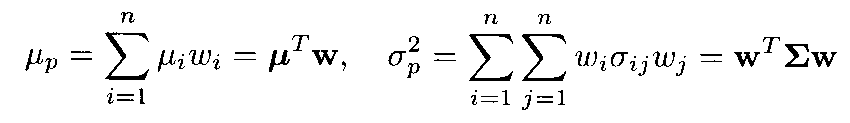

In [ ]:
IPythonImage(filename='portfolio.png', width=600)

dove i pesi $w_i$ (da non confondere con i $W^{asset-i}$ della formula del valore del portafoglio vista prima) sono le percentuali di composizione del portafoglio. Il calcolo del rendimento del portafoglio infatti richiede i $w_i$ e non i $W^{asset-i}$.

Le due equazioni sono qui espresse in forma lineare e poi con la notazione dell'algebra lineare. Sono le consuete formule probabilistiche per il calcolo della media e della varianza di una [**combinazione lineare**](https://it.wikipedia.org/wiki/Combinazione_lineare), quale in effetti è il rendimento di un portafoglio pesato, nel caso in cui le variabili (i rendimenti degli asset) non siano indipendenti. Se per ipotesi (poco realistica) gli asset hanno rendimenti indipendenti, allora, poichè le covarianze sono tutte uguali a zero, la seconda formula si semplifica in $$\sigma_p^2 = \sum_{i = 1}^{n} \sigma_i^2$$<br>

Si noti che $\mu_p$ e $\sigma_p^2$ sono due **numeri singoli**, appunto media e varianza di una singola variabile casuale (il rendimento del portafoglio) sull'**unità di misura di T** (giorno, settimana, mese, anno).<br>

Le suddette formule **NON richiedono la gaussianità**, cioè si possono applicare anche ad asset e portafogli con distribuzioni dei rendimenti (marginali e congiunte) non gaussiane.<br>

Per semplicità si veda il seguente esempio delle formule precedenti applicate al caso ***n=2***, cioè un portafoglio composto da 2 soli asset.

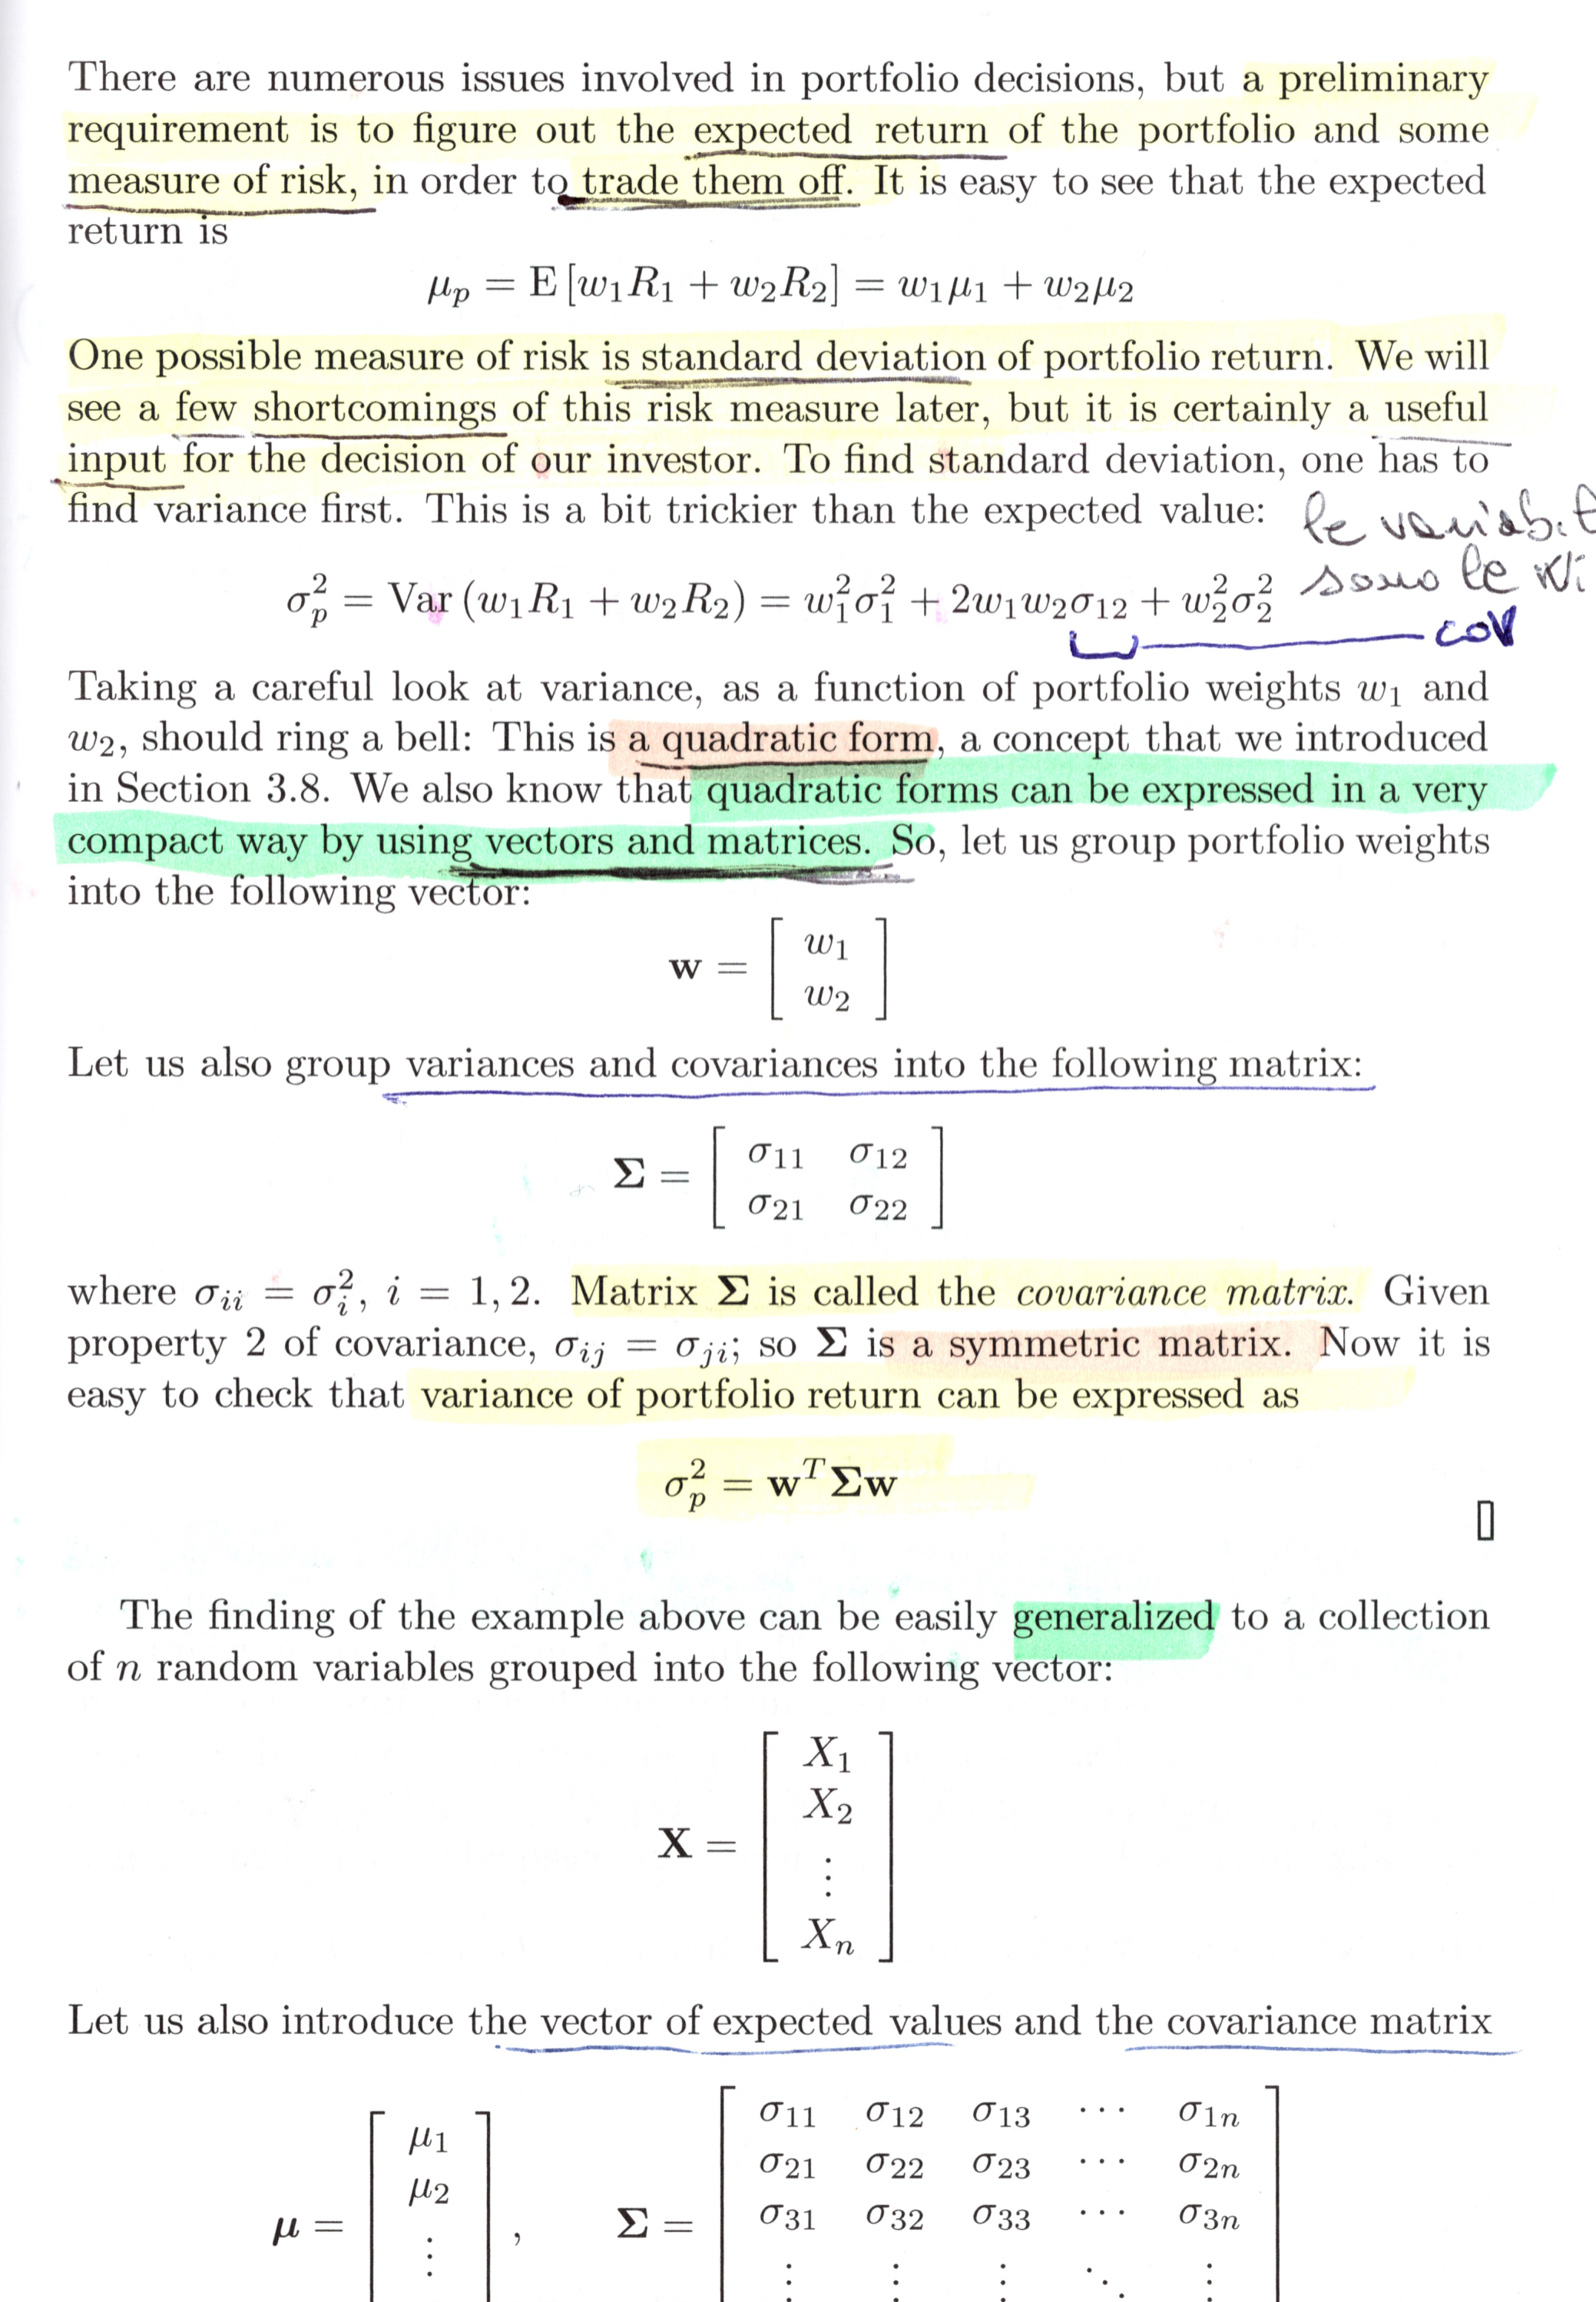

In [ ]:
Image('Brandi_pag_365.png',width=800) if IN_COLAB else display(Image(filename='Brandi_pag_365.png'))

A questo punto interrompiamo momentaneamente la trattazione del VaR per fare una <u>nota importante</u> nella misurazione del rischio di mercato.<br>

Quando si trattano i portafogli, infatti, c'è un problema preliminare: **l'allocazione ottimale del portafoglio**, cioè quali sono i **pesi migliori**, dati certi rendimenti degli asset.

#### L'ottimizzazione del portafoglio

Si ha dunque un **problema di ottimizzazione** (di un portafoglio di investimenti) che cerca il **trade-off (compromesso) ottimale** tra il valore atteso del portafoglio $\mu_p$ - che si vorrebbe il più alto possibile - e la sua variabilità $\sigma^2_p$ - che si vorrebbe la più bassa possibile.
In questo problema le **incognite** non sono più le $\mu_i$ e le $\sigma_{ij}$ come nel calcolo del VaR; ora esse sono *note* e le incognite sono invece i $w_i$ ottimali.

Ancorchè magari non sempre noto e chiaro, il **trade-off** tra il valore atteso e la varianza del profitto / rendimento per un **portafoglio efficiente** può essere rappresentato dalla seguente **frontiera**:
profitto / rendimento *E[X]* (aka, $\mu_p$) e la misura del rischio $\sigma^2_p$.<br>

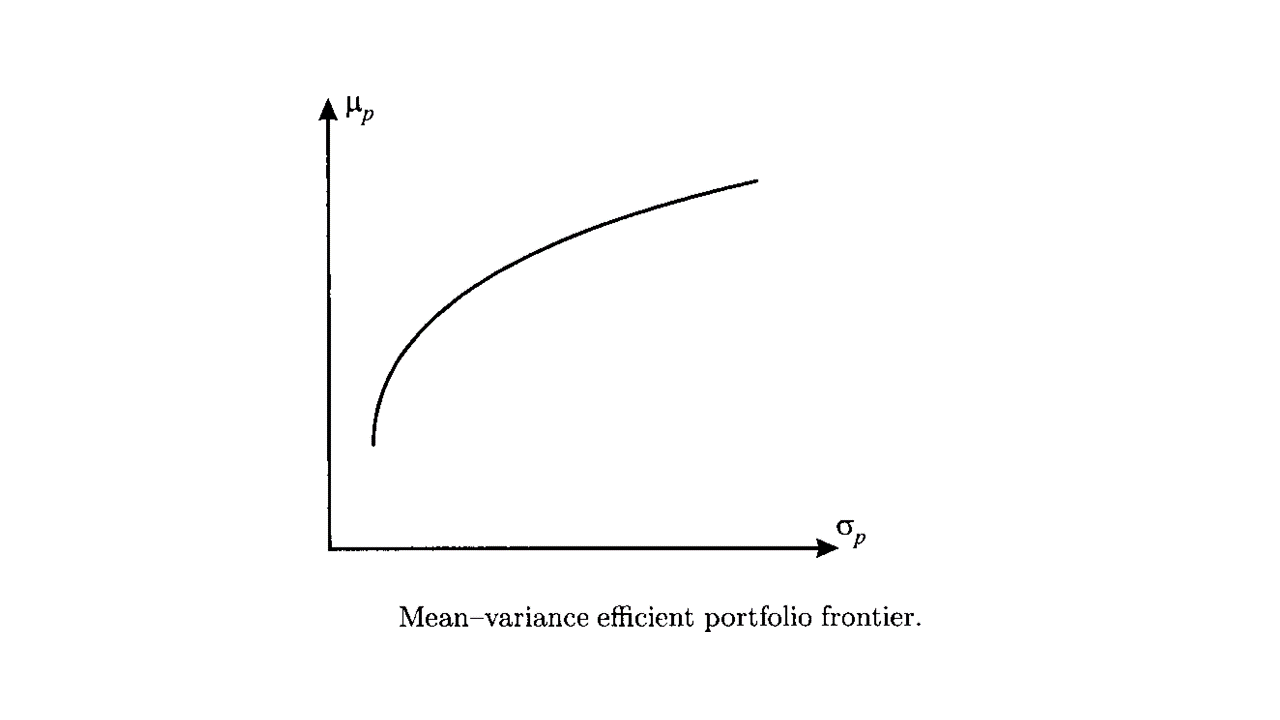

In [ ]:
Image('frontiera.png',width=800) if IN_COLAB else display(Image(filename='frontiera.png'))

Come si vede, la frontiera efficiente è piegata verso nord-ovest.<br> E'
possibile tracciare le frontiere mediante specifici algoritmi di
ottimizzazione.<br> La framework ora vista (detta **dell'efficienza
media-varianza**) ha avuto un ruolo chiave nella moderna teoria finanziaria,
anche se ha alcuni limiti, in particolare l'assunzione che <u>le correlazioni siano
costanti nel tempo</u>. Vedi anche il [modello di ottimizzazione del portafoglio](https://www.performancetrading.it/Documents/Uomini/SF_I_principi_base.htm) di Markowitz.<br>
[Questa](https://plotly.com/python/v3/ipython-notebooks/markowitz-portfolio-optimization/) è una applicazione in Python.


Nuovamente, anche nel caso dell'ottimizzazione del portafoglio, l'assunzione di gaussianità (della distribuzione della *loss*, e quindi anche dei rendimenti) semplifica molto.<br>

#### Esempio di calcolo del VaR analitico di portafoglio

**Torniamo** ora al VaR analitico (multi-variato e multi-periodo) e si veda il seguente **esempio 13_10**, su due asset, nel quale $\mu_{p}$ e $\sigma_{p}$ sono così definiti (in accordo con le formule precedenti):

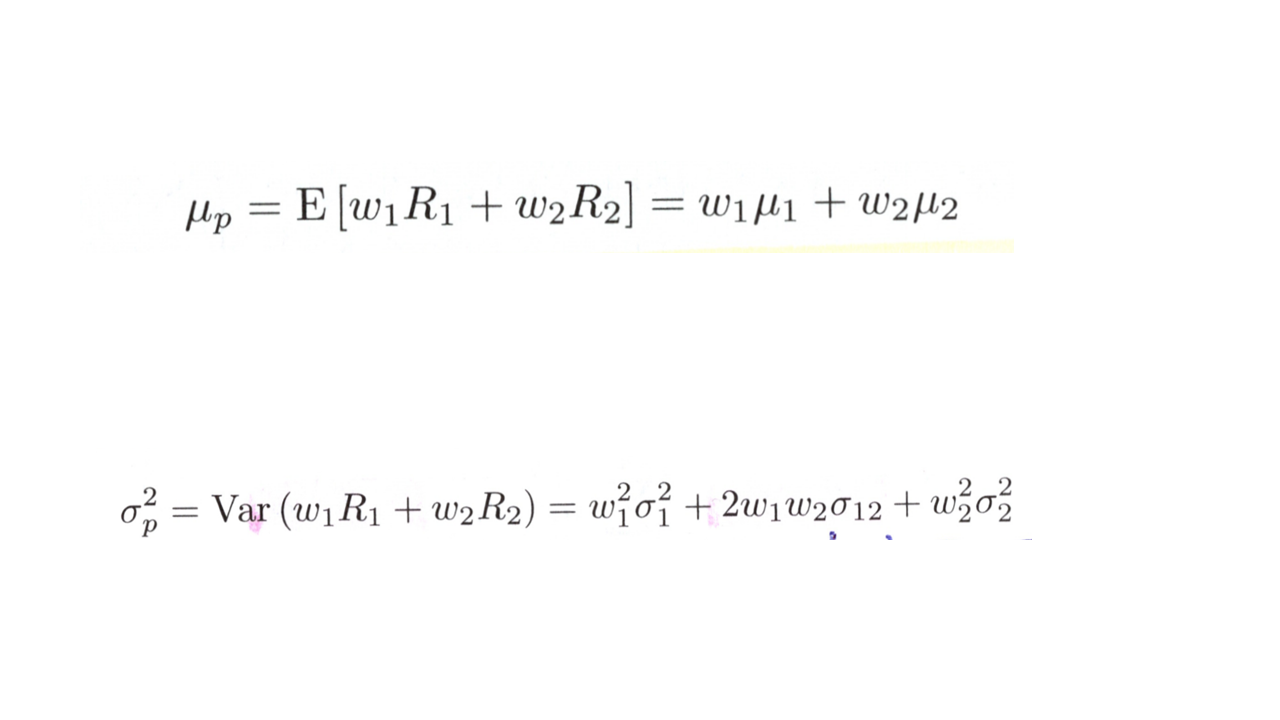

In [ ]:
Image('mu_sigma_p.png',width=500) if IN_COLAB else display(Image(filename='mu_sigma_p.png'))

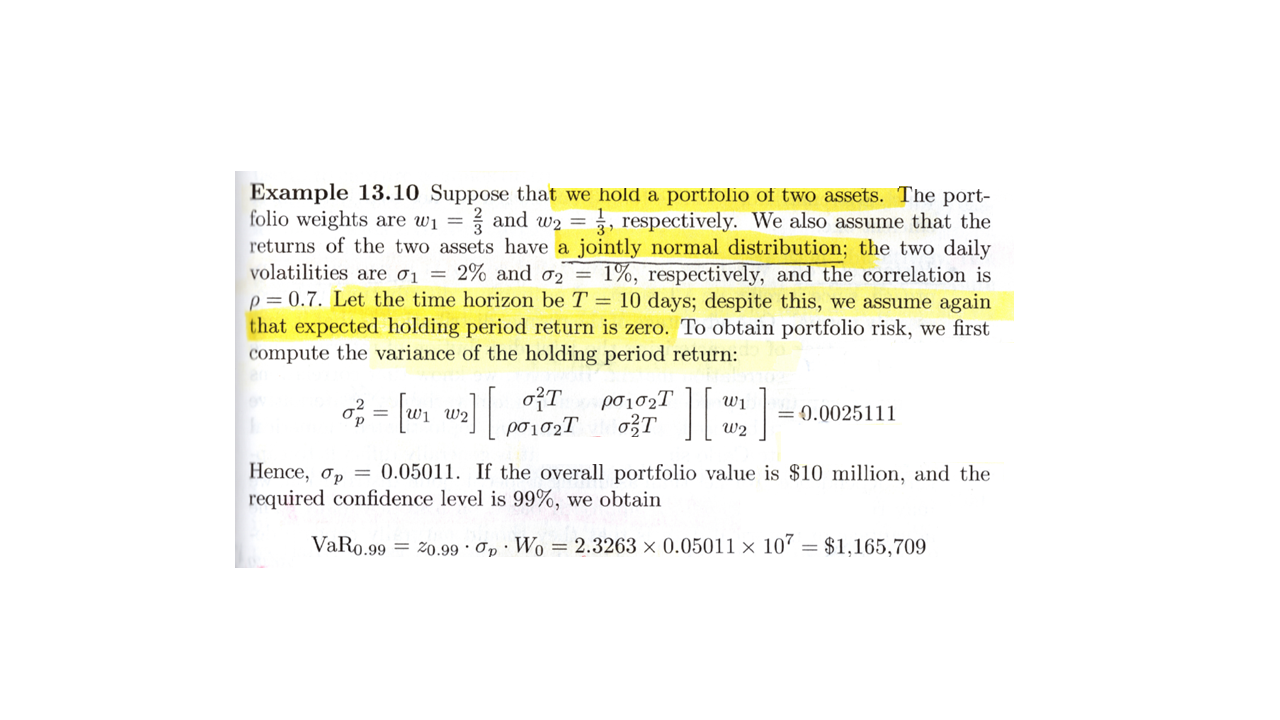

In [ ]:
Image('esempio_13_10.png',width=1500) if IN_COLAB else display(Image(filename='esempio_13_10.png'))

L'esempio 13.10 calcola il VaR giornaliero con T=10. L'espressione "time horizon = 10 days" non è precisa. La granularità di questo VaR è data da $\sigma$, che è qui definita "giornaliera". T=10 è solo il numero di periodi (l'orizzonte temporale), che potrebbero essere settimane o mesi se la variabilità fosse settimanale o mensile.

Il calcolo di $\mu_p$ utilizza due proprietà del valore atteso:
* il valore atteso di una combinazione lineare è uguale alla combinazione lineare delle singole variabili, cioè: $E[X+Y] = E[X] + E[Y]$
* il valore atteso di una variabile casuale moltiplicata per una costante è uguale al prodotto della costante per il valore atteso della variabile casuale, cioè: $E[cX] = c*E[X]$

e chiama E[X] come $\mu_X$

Nel calcolo di $\sigma_p$ si tiene conto delle due seguenti proprietà della varianza:
* la varianza di una combinazione lineare di variabili casuali è uguale alla combinazione lineare delle varianeze delle singole variabili SOLO SE le singole variabili sono tra di loro indipendenti (o non correlate, se gaussiane), cioè, nel nostro esempio, se $\sigma_{12} \approx 0$.
* $var(cX) = c^2*var(X)$; cioè, a differenza del valore atteso, la *c* esce al quadrato.

**Nota matematica**: si passa dalla matrice di varianza-covarianza vista precedentemente a quella fornita nell'esempio 13_10 (a meno del *T*) poichè, ad esempio per l'elemento (*i=1, j=1*), si ha $\sigma_{12} = \sigma_1\sigma_2\rho_{12}$ (qui $\rho_{12}$ è chiamato semplicemente $\rho$ perchè ci sono solo due variabili). Infatti, per definizione di coefficiente di correlazione si ha $\rho_{12} = \sigma_{12} / \sigma_1\sigma_2$. $\Sigma$ è poi moltiplicata per *T* (e non per $\sqrt{T}$ perchè $\Sigma$ contiene varianze e covarianze e non deviazioni standard, come invece nella formula del VaR analitico semplice), semplicemente moltiplicando ogni elemento di $\Sigma$ per *T*. [in proposito vedi anche *Clifford Ang*, p. 113 al fondo]

NB. [blog] Se il portafoglio ha molti asset, la matrice di varianza - covarianza
(o di correlazione) può essere stimata con un [**factor
model**](https://www.portfolioprobe.com/2012/04/09/three-things-factor-models-do/).
Comunque le varianze-covarianze / correlazioni, insieme alle distribuzioni marginali (univariate), possono non essere sufficienti a stimare la distribuzione congiunta (aka, multivariata) dei rendimenti se essa <u>non è gaussiana</u>, ed occorre allora utilizzare le
[copule](https://it.wikipedia.org/wiki/Copula_(statistica) [Brandimarte1, p. 716].<br>

## VaR con il metodo delle varianze e covarianze

L'<u>applicazione pratica più frequente</u> del VaR è ad un **portafoglio di asset** la cui [distribuzione congiunta](https://it.wikipedia.org/wiki/Distribuzione_congiunta) è assunta **gaussiana** con matrice di varianza-covarianza $\Sigma$ **stimata dai dati** [^11].<br>
E' cioè un VaR analitico nel quale la variabilità $\Sigma$ <u>non è nota e dunque è stimata dai dati storici</u>, in termini probabilistici si dice **inferita** dai dati campionari.
   
    
[^11]: *Clifford Ang*

**Note matematiche sulla distribuzione congiunta**:
* La distribuzione congiunta è data dal prodotto delle distribuzioni marginali (aka, univariate) solo se le variabili (cioè, in questo caso, i rendimenti dei vari titoli nel periodo *t*) sono <u>indipendenti</u> (o semplicemente <u>non-correlate</u> per le gaussiane).<br>
* La distribuzione congiunta gaussiana gode della proprietà che, in caso di correlazione tra le variabili, la matrice di correlazione è sufficiente a "colmare" il gap tra la distribuzione congiunta ed il prodotto delle distribuzioni marginali. Altrimenti il gap è colmato dalla [**copula**](https://it.wikipedia.org/wiki/Copula_(statistica)) [*Brandimarte1, sezione sul VaR*].

### Pro e contro del metodo analitico
* pro:
    - facile da calcolare
    - non richiede troppe osservazioni (rendimenti)
* contro:
    - le osservazioni (rendimenti) devono essere gaussiani (infrequente, code magre)
    - non funziona bene con strutture di portafoglio non-lineari
    - occorre stimare la matrice var-cov (può richiedere tempo perchè i **parametri possono essere moltissimi!**)

**Nota**: Problema generale della statistica: stimare un parametro della popolazione (ad esempio un valore atteso) tramite un campione limitato.<br>

La semplificazione gaussiana è attraente, ma questo metodo non è probabilmente il metodo migliore. I rendimenti dei titoli hanno spesso distribuzioni non gaussiane e nemmeno simmetriche, come fu dimostrato già nel 1965 da Fama. L'uso del modello gaussiano comporta una pericolosa sottostima dei valori molto bassi dei rendimenti, che sono invece tipici proprio dei periodi di crisi!.<br>


**Per fortuna c'è un altro metodo di calcolo del VaR che non richiede questa assunzione, quello <u>storico</u>**.
Per semplicità di trattazione, vedremo però prima quello simulato con Montecarlo, utile in alcuni casi.

## VaR simulato con Montecarlo

*Da Brandimarte1*<br>
Nel calcolo del VaR analitico abbiamo sfruttato la
**trattabilità analitica** della distribuzione gaussiana ed il fatto che il
rendimento delle azioni *Quacko corp.* fosse **l'unico fattore di rischio**.<br>
Nella realtà, altri fattori di rischio possono essere presenti, come ad esempio
**il tasso di interesse** e **l'inflazione**. Il portafoglio può anche inludere
**derivati**, il cui valore è dato da una complicata funzione dei valori degli
asset sottostanti. Anche se assumiamo che i fattori di rischio sottostanti siano
distributi in modo gaussiano (il che è discutibile!), il valore del portafoglio
può essere una <u>funzione non-lineare di essi</u>, e quindi la trattabilità analitica
della gaussiana è persa. [Infatti una funzione non-lineare di gaussiane non è più gaussiana]<br> Una possibilità è allora l'utilizzo della
simulazione di Montecarlo, che è uno strumento molto flessibile anche se non
necessariamente il più flessibile. Vedi sezione 9.7. di Brandimarte.<br>

*prof. Karasan*:<br>
La simulazione Montecarlo serve a stimare quando non c'è una forma chiusa (cioè una formula) e si basa sul campionamento da una certa distribuzione. E' molto veloce.<br>
<u>Il metodo del VaR Montecarlo è molto simile al VaR simulato storicamente</u>, che tratteremo tra poco, tuttavia non usa la storia ma genera campioni da una data distribuzione.<br>
3 passi:<br>
* definire il dominio
* generare i numeri casuali
* iterare ed aggregare il risultato

*Da qui in poi, liberamente adattato da
[qui](https://www.youtube.com/watch?v=k1XAO1YCV8I).*

Le **simulazioni** di Montecarlo possono essere utili in un numero molto grande di scenari. La
finanza in particolare è un campo in cui la matematica e la statistica hanno
portato a grandi progressi (a volte in bene, a volte in male). Il [**Value at
Risk**](https://en.wikipedia.org/wiki/Value_at_risk) è uno tra i molti esempi di
possibile applicazione della simulazione.<br>

Spesso non cè un unico fattore di rischio (il rendimento), ma vari: ad esempio,
l'inflazione, i tassi di interesse, la presenza di complessi derivati, ecc. Non
possiamo quindi utilizzare la distribuzione gaussiana.

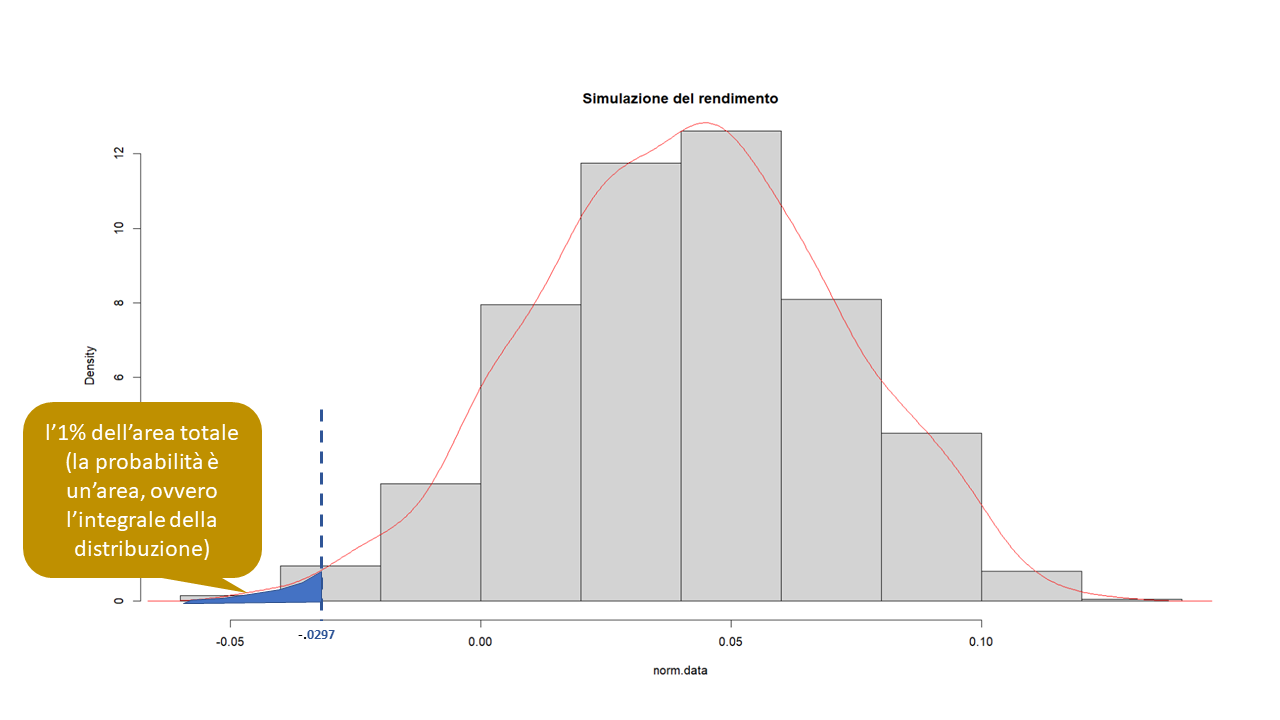

In [ ]:
IPythonImage(filename='area.png')

Con l'approccio simulato di Montecarlo si simula un processo stocastico che rappresenta il
**comportamento del titolo** e poi, una volta calcolati i rendimenti
logaritmici, basta estrarre il rendimento percentile del 95% e moltiplicarlo per
il valore del portafoglio al tempo 0.

**Il VaR simulato con Montecarlo è molto utile se accompagnato dal VaR storico, in una forma dunque *ibrida*.** [Vedi analisi MonteCarlo in Excel]

## VaR storico (simulato)

*prof. Karasan*:<br>
Un'assunzione forte come quella gaussiana può produrre stime errate, se violata. Il metodo del VaR storico (simulato) è **empirico**: anzichè usare un metodo parametrico, cerca i quantili **empirici**, cioè gli equivalenti della tavola Z del metodo analitico, nei **dati storici**. Supponiamo sia CI = 0.95, allora si usa 0.05 al posto dei valori della tavola Z, e tutto quello che abbiamo da fare è moltiplicare il quantile per l'investimento iniziale.<br>

*Clifford Ang, p. 118*:<br>
Il VaR storico sfrutta le **proprietà distributive dei dati effettivi**, cioè la distribuzione empirica dei rendimenti.<br>

*Brandimarte*:<br>
Sin qui abbiamo utilizzato un approccio **parametrico**,
perchè si è utilizzata una **distribuzione di probabilità teorica** (in modo
analitico o simulato), non necessariamente gaussiana. Uno dei vantaggi della
gaussiana è di semplificare la caratterizzazione della distribuzione congiunta
dei rendimenti perchè è sufficiente la semplice matrice di correlazione, che
comunque - come noto - non cattura tutta la dipendenza tra le varaibili casuali
(i rendimenti).A questo scopo infatti serve la **copula**. Si possono usare
altre distribuzioni, ad esempio la *t di Student*, oppure si può ricorrere a
metodi numerici od appunto alla simulazione MC, ma in generale è difficile
catturare la dipendenza.<br> Anzichè assumere una specifica distribuzione per i
rendimenti, si può utilizzare un approccio **non parametrico basato su dati
storici.** Il vantaggio dei dati storici è che essi dovrebbero naturalmente
catturare la dipendenza. Li possiamo quindi combinare, ad esempio con una
procedura di *bootstrapping*, in modo da generare scenari futuri e stimare il
VaR attraverso la simulazione storica.

> Il punto chiave del VaR storico è che **cade ogni ipotesi sulla distribuzione dei rendimenti** (gaussiana, t, assimmetrica, ecc) - presente invece sia nel VaR analitico che nel VaR Montecarlo, detti infatti metodi *parametrici* - e si usa la [distribuzione empirica](https://it.wikipedia.org/wiki/Funzione_di_ripartizione_empirica) come stimatore della distribuzione dei rendimenti.

### VaR storico a T-giorni

Assumendo che i rendimenti siano *iid*, il VaR storico a T-giorni si calcola come il VaR analitico a T giorni, cioè con la
regola della radice quadrata (*square root rule*), moltiplicando il VaR ad 1
giorno per la radice di T. Ad esempio, il VaR all'1% a 10-giorni è:<br>

### L'aggregazione a livello di portafoglio

Da [blog]: Per il calcolo del VaR si parte dalle informazioni **a livello di asset** e le
si combina **a livello di portafoglio**.<br>

I due metodi sono:

-   **estimate then collapse** Il calcolo del VaR richiede la conoscenza della
    **distribuzione congiunta dei rendimenti** (completa, le correlazioni
    possono non essere sufficienti, occorrono le copule). Particolarmente
    difficile può essere modellare le code "cattive", dove si perde denaro
    [^21].<br>

-   **collapse then estimate** Si stima la distribuzione dei singoli rendimenti,
    in base alla loro storia individuale, tramite il **fitting** o la
    **distribuzione empirica** (due cose diverse).

[^21]: *Brandimarte 2, p. 80*

Vedi
[qui](https://www.r-bloggers.com/2012/10/the-basics-of-value-at-risk-and-expected-shortfall/).

### Conclusioni sul VaR storico (simulato)

Il metodo storico (simulato) assume in modo implicito che ci sia continuità temporale negli andamenti dei rendimenti, senza eventi *disrupting*. Il passato è usato per prevedere il futuro.<br>

Pro del metodo VaR simulato storico:
* non ci sono assunzioni di distribuzione
* funziona bene anche con le strutture di portafoglio non-lineari
* cattura naturalmente anche la dipendenza dei dati (tra righe o tra colonne)
* facile da calcolare<br>

Contro;
* richiede molti dati
* richiede molto potere computazionale

# Limiti del VaR

Il VaR ha alcuni limiti, dati dalla sua natura di *quantile*:

-   il VaR non distingue tra forme differenti delle code; si consideri questa
    figura:

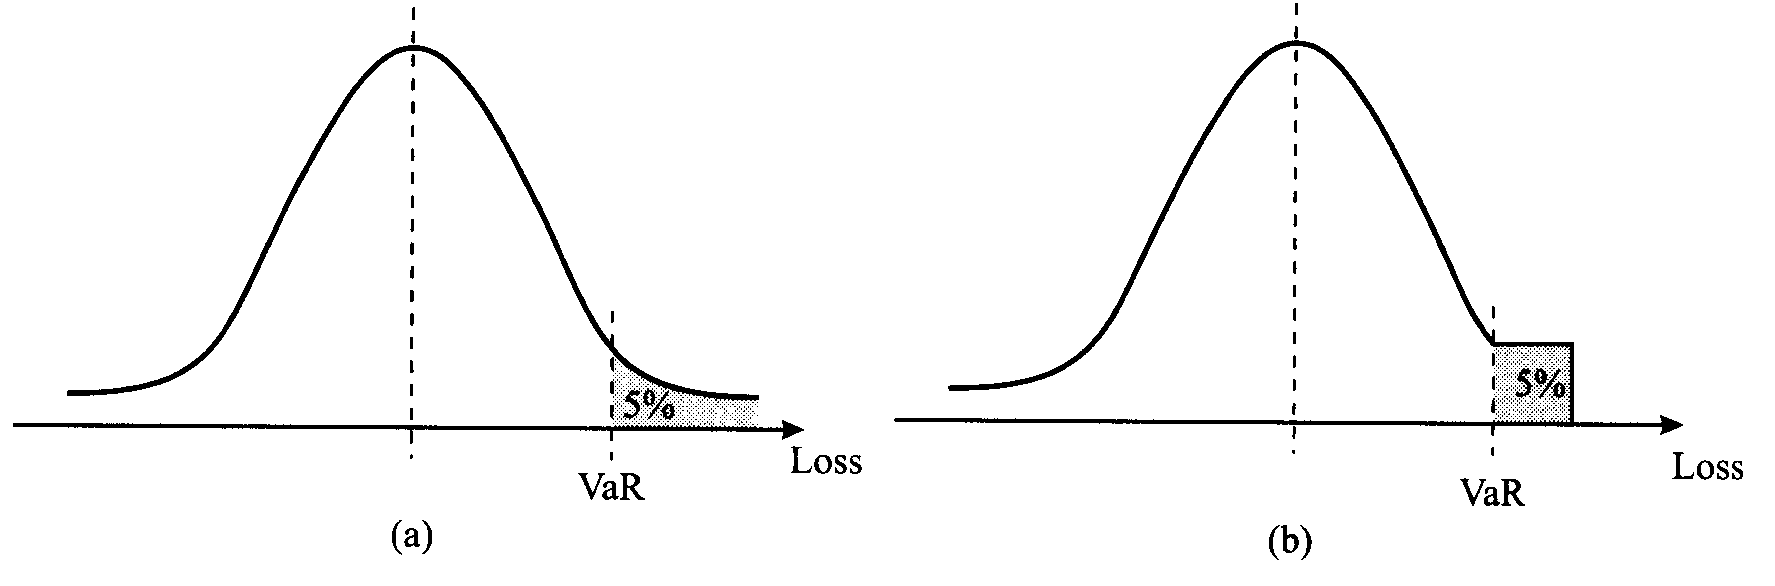

In [ ]:
IPythonImage(filename='Brandimarte1_Fig_13_8.png')

ancorchè le due aree a dx del VaR siano entrambe del 5% (perchè il VaR
    appunto è un quantile), nel caso (b) c'è un limite superiore alla loss;
    cioè, il rischio in (a) è maggiore che in (b). Cioè il VaR non tiene in
    conto il **tail risk** (il rischio di coda), come ben si vede da questa ulteriore figura:

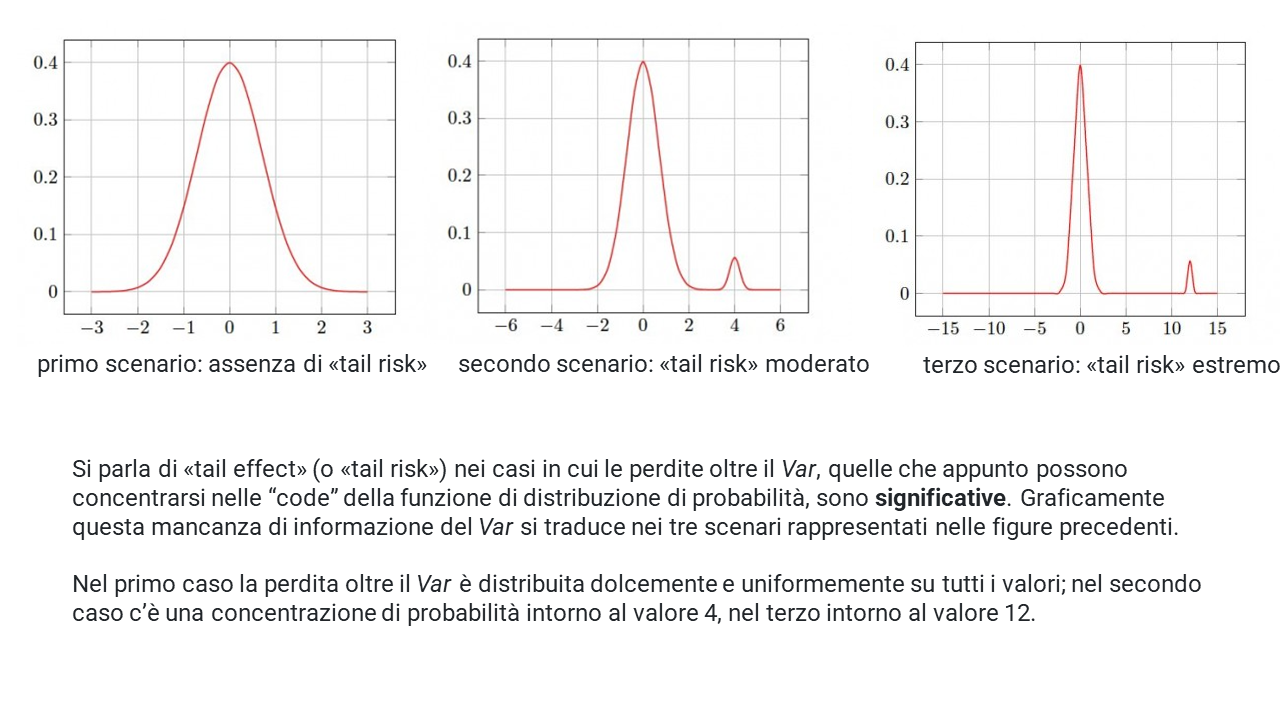

In [ ]:
IPythonImage(filename='tail_risk.png')

Per ovviare a questo problema è stato introdotto il **VaR condizionato([*CVaR*](https://www.investopedia.com/terms/c/conditional_value_at_risk.asp))**,
anche detto **Expected Shortfall**. Vedi più avanti.<br>

-   secondo limite del VaR: manca della proprietà della *subadditività*; ovvero,
    data una misura di rischio ${\rho}$, dev'essere:

    $\rho$(A+B) $\le$ $\rho$(A) + $\rho$(B),

    dove A e B sono due asset del portafoglio [intuitivamente, il rischio è
    ridotto dalla diversificazione].

    Il seguente classico contro-esempio - che utilizza la definizione generale di VaR come il numero più piccolo che soddisfa: $Pr[L_T \le VaR_{1-\alpha}] \ge 1-\alpha$ - mostra appunto come il VaR non sia
    subadditivo [mentre il CVaR lo è]:

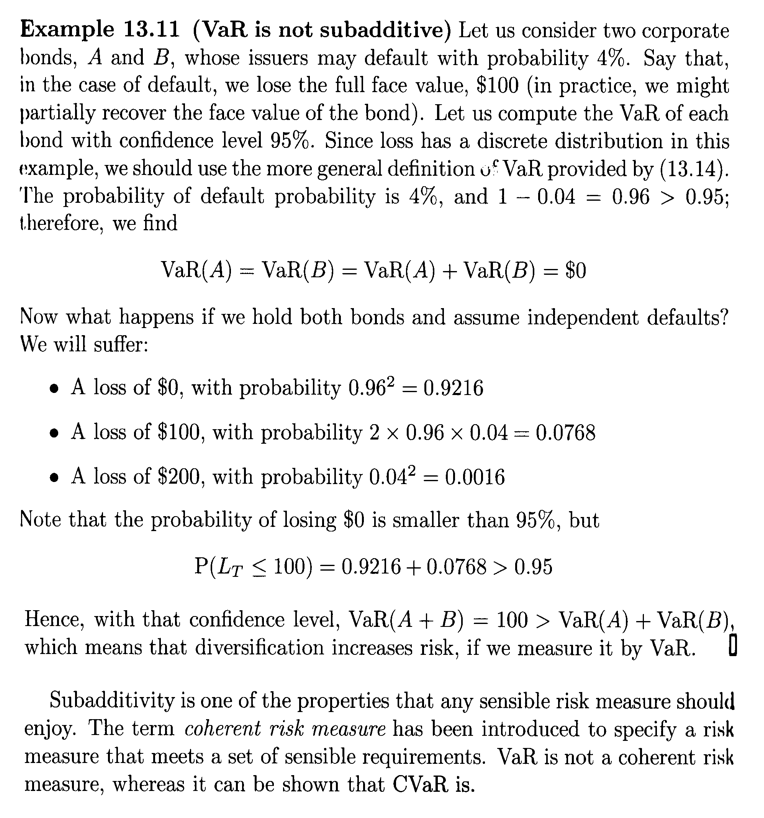

In [ ]:
IPythonImage(filename='VaR_non_subadditivo.png')

-   infine (terzo limite), il VaR non risponde a questa domanda: "se le perdite eccedono il VaR, quanto grandi possono essere?". Ed anche per questa ulteriore ragione è stata introdotta la [Expected Shortfall](https://en.wikipedia.org/wiki/Expected_shortfall#:~:text=Expected%20shortfall%20(ES)%20is%20a,of%20cases.) [=CVaR!]

> ll VaR rimane comunque uno strumento semplice, intuitivo, facile da sottoporre a verifiche di [*backtesting*](https://corporatefinanceinstitute.com/resources/data-science/backtesting/). E perciò molto diffuso ed importante.

# Stressed VaR
Il calcolo del VaR su un periodo storico di **12 mesi** di <u>stress finanziario significativo</u>. Vedi notebook Python.

# Expected Shortfall
Questo indicatore prende in considerazione la **perdita attesa** nei momenti in cui la perdita (la *loss* $L_T$) supera la soglia del VAR. Ci indica quindi qual è la perdita attesa nell’intervallo di confidenza destro, non preso in considerazione dal VAR.<br>

A differenza del VaR, ES si **focalizza sulla coda** (destra) della distribuzione della loss. Cioè, ES ci permette di tenere in conto **i rischi imprevisti del mercato**, tipici dei periodi di crisi.<br>

Vediamo la teoria matematica dell'ES. Ci sono due modi di calcolare l'ES: **gaussiano** e **storico**. Come per il
VaR, la differenza tra i due metodi sta nell'assunzione (o nella sua mancanza)
di <u>gaussianità</u> dei rendimenti del portafoglio (e quindi anche, a valle, del P&L e della loss).

## ES analitico (gaussiano)
Se la loss è <u>continua</u>, come è in genere, la formula di calcolo dell'ES **analitico** è la seguente:

$$ES_\alpha = E[L|L \ge VaR_\alpha]$$

Tale formula bene evidenzia la natura della ES: il valore atteso della loss, condizionata alla coda destra.<br>

**Attenzione**: in letteratura vige l'uso di indicare $ES_\alpha$, e non $ES_{1-\alpha}$, perchè ES si focalizza sulla coda destra di area $\alpha$. Preferisco tuttavia, per uniformità con la notazione del VaR, utilizzare la seguente formula <u>equivalente</u>, con la notazione modificata da $\alpha$ ad $1-\alpha$.

$$ES_{1-\alpha} = E[L|L \ge VaR_{1-\alpha}]$$


ES è anche esprimibile con questa formula <u>alternativa</u>, equivalente alla precedente dal punto di vista matematico:

$$ES_{1-\alpha} = \frac{1}{\alpha}\int_{1-\alpha}^{1}VaR_udu$$

dove la variabile di integrazione *u* viene fatta variare da $(1-\alpha)$ ad 1, cioè progressivamente rimpicciolendo $\alpha$.

Cioè ES non è nient'altro che la "media pesata delle probabilità $\alpha$ di perdita" (Karasan, p. 141), perchè la differenza di area sottesa tra $1-\alpha$ ed 1 è proprio $\alpha$.

Quest'ultima formula alternativa bene evidenzia come VaR ed ES siano <u>concetti collegati</u>, perchè **esprime ES nei termini del VaR**.
> Sia $VaR_{1-\alpha}$ che $ES_{1-\alpha}$ sono **due quantili della distribuzione della loss $L_T$**, con $ES_{1-\alpha} \ge VaR_{1-\alpha}$ <u>, a parità di $\alpha$ ovviamente</u> [*QRM*, p. 25 e soprattutto p. 70], come ben si vede dalla seguente figura:

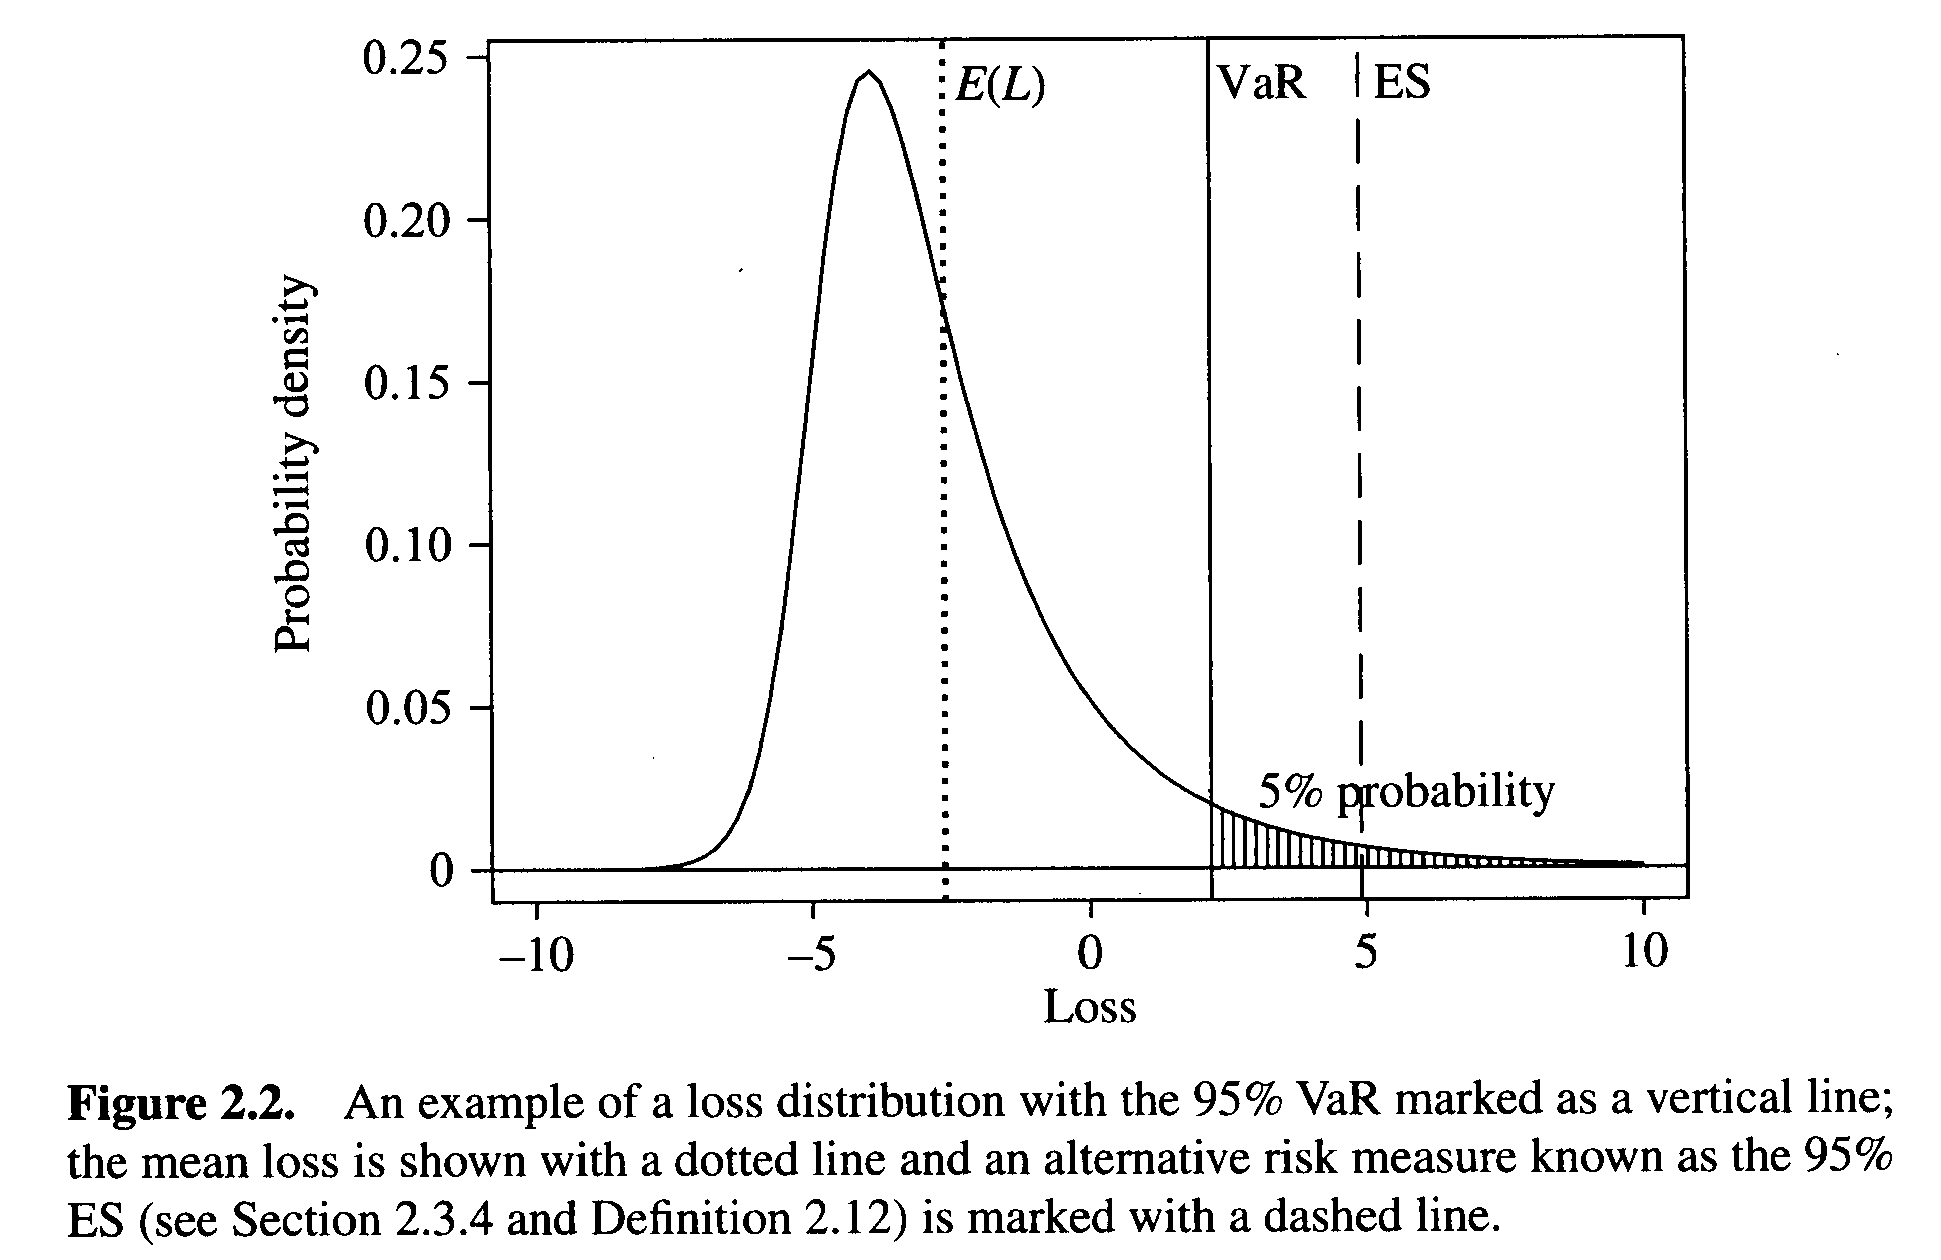

In [ ]:
IPythonImage(filename='QRM_Fig_2_2.png')

## ES storico

ES può essere calcolato anche in base ai dati storici dei rendimenti. Come nel il VaR storico, si rilassa l'assunzione di gaussianità e si usano i quantili empirici anzichè quelli teorici.

# Confronto tra VaR ed ES

Ci aspettiamo che **i valori di ES siano loss maggiori del VaR** perchè, per
definizione, <u>l'ES è la loss media quando la loss eccede il VaR</u>.<br>

Vediamo un **confronto** tra VaR ed ES <u>analitici</u>, utilizzando sia il modello <u>gaussiano</u> che quello di <u>*t di Student*</u>, con differenti valori di $\alpha$. Infatti, per ovviare al limite del VaR analitico classico (gaussiano) delle code troppo poco piatte, un approccio talora proposto è quello di usare la stessa formula, ma con i quantili della distribuzione [***t di Student***](https://it.wikipedia.org/wiki/Distribuzione_t_di_Student). Si assume cioè che:
$(L_T - \mu) / \sigma \sim t_\nu$.<br>
Vediamo questo utile **esempio**:

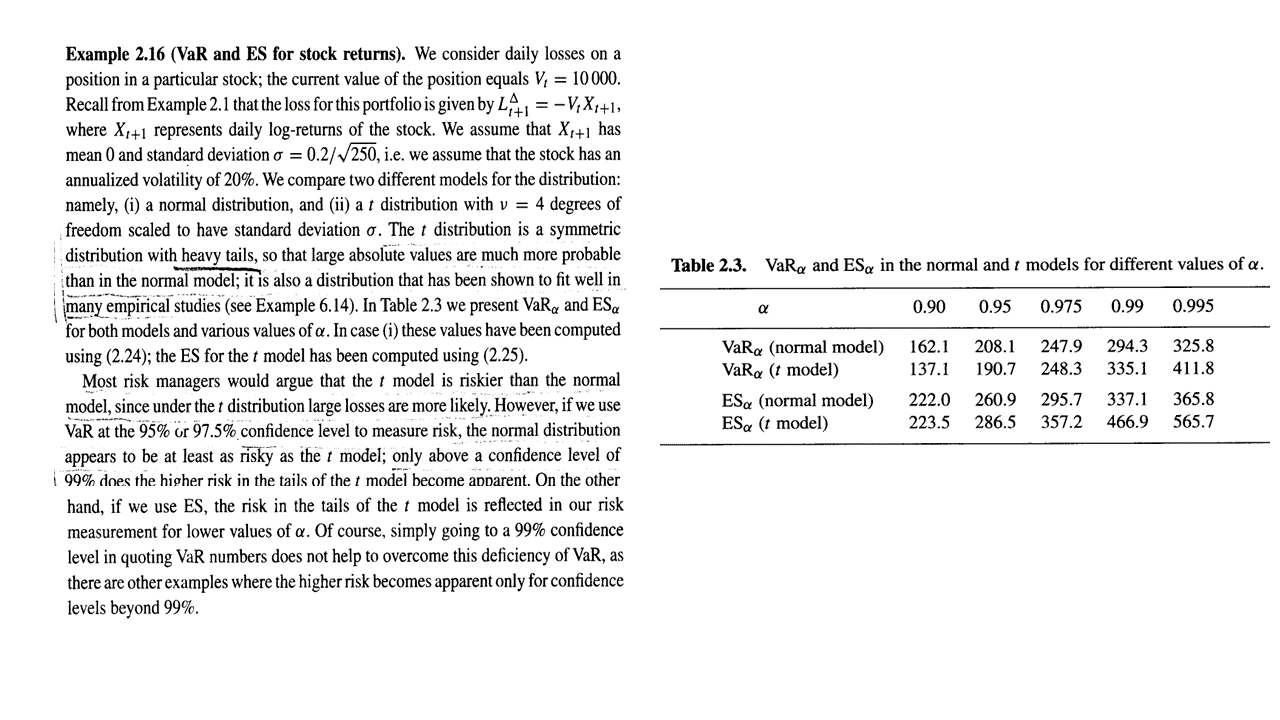

In [ ]:
IPythonImage(filename='QRM_table_2_3.png')

> Poichè $ES_{1-\alpha}$ è definita come valore atteso di tutte le loss che sono maggiori od uguali al $VaR_{1-\alpha}$, essa è **sensibile alla severità delle loss eccedenti $VaR_{1-\alpha}$**.

Se, per il calcolo del VaR e della ES, si usa il modello con la distribuzione *t di Student*, un problema pratico è: **quanti gradi di libertà usare?** (il parametro $\nu$).<br>

> When calculating parametric Value at Risk (VaR) using the Student's t-distribution, the degrees of freedom play a crucial role in determining the shape of the distribution and, consequently, the risk assessment.<br>
In the context of the t-distribution, the degrees of freedom (often denoted as "ν" or "df") represent a parameter that influences the fatness of the tails of the distribution. The higher the degrees of freedom, the closer the t-distribution approximates a normal (Gaussian) distribution with thinner tails. Conversely, lower degrees of freedom result in thicker tails, indicating greater uncertainty or volatility.<br>
Typically, in financial risk management and statistics, you'll encounter two common scenarios regarding degrees of freedom:
> 1. If you have a large sample size and the data closely resembles a normal distribution, you can use a t-distribution with a high degree of freedom, such as 30 or more. In this case, the t-distribution is very similar to a normal distribution.
> 2. If you have a small sample size or believe that the data has heavier tails than a normal distribution (indicating more extreme outcomes), you might use a t-distribution with fewer degrees of freedom, which has thicker tails. This acknowledges the additional uncertainty associated with a smaller sample or the presence of outliers.<br>

> In the context of calculating VaR, selecting an appropriate degree of freedom is essential to capture the risk accurately. A higher degree of freedom might be suitable for less volatile and normally distributed data, while a lower degree of freedom might be more appropriate for data with higher volatility or potential extreme events. The choice of degrees of freedom should align with the characteristics of the data being analyzed to provide a realistic estimate of VaR.<br>

Per un ottimo confronto tra il VaR analitico con la gaussiana e quello con la t di Student vedi [questo post](https://quantatrisk.com/2015/12/02/student-t-linear-value-at-risk/).

# Altre misure di rischio

Oltre a deviazione standard / varianza, VaR ed ES, esistono altre misure
    di rischio.<br> VaR ed ES sono infatti misure di volatilità
    **close-to-close**, cioè considerano solo i <u>prezzi di chiusura</u> del
    titolo nelle varie giornate. Il costo è che, per avere una buona stima della
    volatilità, occorre una lunga serie storica, i cui primi valori possono
    anche essere non più rappresentativi.<br> In alternativa a VaR ed ES, si
    possono dunque utilizzare metriche di volatilità (rischio) che utilizzano
    anche **i prezzi intra-giorno** del titolo (open, close, high, low), e che
    quindi sono più "efficienti" di quelle close-to-close.<br> Ad esempio:<br>

-   Parkinson

-   Garman-Klass

-   Rogers, Satchell e Yoon

-   Yang e Zhang

Per approfondimenti su queste misure si rimanda alla letteratura del settore,
per mancanza di tempo.<br>

Nel terzo corso potremo vedere **misure di rischio avanzate**:
* VaR *denoised* per separare il segnale dal rumore;
* misure basate sul Machine Learning (prof. Karasan): ES che tiene in conto il rischio di liquidità (*liquidity-augmented ES*) e l'*effective cost*.


# Fonti e bibliografia
* prof. Brandimarte del Politecnico di Torino: [qui](https://www.amazon.it/Introduction-Financial-Markets-Quantitative-Approach/dp/1118014774/ref=sr_1_1?__mk_it_IT=%C3%85M%C3%85%C5%BD%C3%95%C3%91&crid=3CKEXB8Q32BWH&keywords=brandimarte+paolo&qid=1703539852&s=books&sprefix=brandimarte+paolo%2Cstripbooks%2C64&sr=1-1) e soprattutto [qui](https://www.amazon.it/Quantitative-Methods-Introduction-Business-Management/dp/0470496347/ref=sr_1_6?__mk_it_IT=%C3%85M%C3%85%C5%BD%C3%95%C3%91&crid=3CKEXB8Q32BWH&keywords=brandimarte+paolo&qid=1703539905&s=books&sprefix=brandimarte+paolo%2Cstripbooks%2C64&sr=1-6).
* il [testo principale](https://www.amazon.it/Quantitative-Risk-Management-Concepts-Techniques/dp/0691166277/ref=sr_1_1?__mk_it_IT=%C3%85M%C3%85%C5%BD%C3%95%C3%91&crid=3SAOMMV8KJGBD&keywords=quantitative+risk+management&qid=1703539966&s=books&sprefix=qunatitative+risk+management%2Cstripbooks%2C64&sr=1-1) di Risk Management quantitativo
* il testo del prof. Karasan sul [ML finanziario con Python](https://www.amazon.it/Machine-Learning-Financial-Management-Python/dp/1492085251/ref=sr_1_fkmr0_1?__mk_it_IT=%C3%85M%C3%85%C5%BD%C3%95%C3%91&crid=TIA0Q99SLXML&keywords=abdulla+karasan&qid=1703540001&s=books&sprefix=abdulla+karasan%2Cstripbooks%2C69&sr=1-1-fkmr0)
* il testo di [Clifford Ang](https://www.amazon.it/Analyzing-Financial-Implementing-Models-Using/dp/3030641570/ref=sr_1_1?__mk_it_IT=%C3%85M%C3%85%C5%BD%C3%95%C3%91&crid=2W3G8UYD3Y548&keywords=clifford+ang&qid=1703540067&s=books&sprefix=cliffor+ang%2Cstripbooks%2C66&sr=1-1)